In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import cv2

import json

current_directory = os.getcwd()

## Load ScanNet scene

In [8]:
scan = "scene0000_00"

scan_path = os.path.join(current_directory, "data/scans", scan)
scene_mesh_path = os.path.join(scan_path, scan + "_vh_clean_2.ply")
scene_mesh = o3d.io.read_triangle_mesh(scene_mesh_path )
segmentation_mesh_path = os.path.join(scan_path, scan + "_vh_clean_2.labels.ply")
segmentation_mesh = o3d.io.read_triangle_mesh(segmentation_mesh_path)

o3d.visualization.draw_geometries([scene_mesh])

## Select a class

The class must be chosen among one of the raw_category in the [scannetv2-labels.combinesd.tsv](data/scannetv2-labels.combined.tsv)

In [9]:
class_name = 'guitar'

with open(os.path.join(scan_path, scan + '.aggregation.json')) as f:
    aggregation_data = json.load(f)

object_ids = []
for seg_group in aggregation_data['segGroups']:
    if seg_group['label'] == class_name:
        object_ids.append(seg_group['objectId'])

if not object_ids:
    print("No objects found for class:", class_name)
else:
    print(f"Found {len(object_ids)} objects for class {class_name}: {object_ids}")


Found 1 objects for class guitar: [47]


## Select an object

In [10]:
object_id = 47

for seg_group in aggregation_data['segGroups']:
    if seg_group['objectId'] == object_id:
        selected_instance_segments = seg_group['segments']

# Load over-segmentation data
with open(os.path.join(scan_path, scan + '_vh_clean_2.0.010000.segs.json')) as f:
    segmentation_data = json.load(f)

# Map from vertex index to segment ID
vertex_to_segment = np.array(segmentation_data['segIndices'])

# Filter vertices based on whether their segment ID is in the selected instance segments
is_instance_vertex = np.isin(vertex_to_segment, selected_instance_segments)

instance_vertices_mask = is_instance_vertex
instance_vertex_indices = np.where(instance_vertices_mask)[0]
instance_vertex_indices_set = set(instance_vertex_indices)

# Filter faces of the mesh. A face is included if all its vertices are part of the instance
faces = np.asarray(scene_mesh.triangles)
face_mask = np.all(np.isin(faces, instance_vertex_indices), axis=1)

instance_faces = faces[face_mask]

# Now, create a new mesh for the instance
instance_vertices = np.asarray(scene_mesh.vertices)[instance_vertex_indices]

# We need to remap the vertices indices in the faces to their new indices
vertex_remap = {old_idx: new_idx for new_idx, old_idx in enumerate(instance_vertex_indices)}
instance_faces_remap = np.vectorize(vertex_remap.get)(instance_faces)

# Create the mesh for the selected instance
instance_mesh = o3d.geometry.TriangleMesh()
instance_mesh.vertices = o3d.utility.Vector3dVector(instance_vertices)
instance_mesh.triangles = o3d.utility.Vector3iVector(instance_faces_remap)
instance_mesh.compute_vertex_normals()

if hasattr(scene_mesh, 'vertex_colors'):
    instance_vertex_colors = np.asarray(scene_mesh.vertex_colors)[instance_vertex_indices]
    instance_mesh.vertex_colors = o3d.utility.Vector3dVector(instance_vertex_colors)

o3d.visualization.draw_geometries([instance_mesh])

## Select frames that contain the specific object

### Export camera parameters

In [11]:
reader_directory = os.path.join(current_directory, "scripts/SensReader")
sens_file = os.path.join(scan_path, scan + ".sens")
output_directory = os.path.join(current_directory, "outputs/reader/"+scan)

os.system(f"python {os.path.join(reader_directory, 'reader.py')} --filename {sens_file} --output_path {output_directory} --export_color_images --export_poses --export_intrinsics")

pose_directory = os.path.join(output_directory, "pose")
originals_directory = os.path.join(output_directory, "color")
pose_files = [f for f in os.listdir(pose_directory) if f.endswith('.txt')]
frame_indices = [int(f.split('.')[0]) for f in pose_files]
intrinsics = np.loadtxt(os.path.join(output_directory, "intrinsic", "intrinsic_color.txt"))  # Camera intrinsics
extrinsics = np.loadtxt(os.path.join(output_directory, "intrinsic", "extrinsic_color.txt"))  # Camera estrinsic
camera_intrinsics = intrinsics[:3, :3]

Namespace(filename='/Users/lara/Desktop/Making-CLIP-features-multiview-consistent/data/scans/scene0000_00/scene0000_00.sens', output_path='/Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00', export_depth_images=False, export_color_images=True, export_poses=True, export_intrinsics=True)
loading /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/data/scans/scene0000_00/scene0000_00.sens...loaded!
exporting 5578 color frames to /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00/color


### Select minimum_vertices in an image and image dim

In [6]:
minimum_vertices = 100
original_path = os.path.join(originals_directory, "0.jpg")
original = cv2.imread(original_path)
image_height, image_width = original.shape[:2]

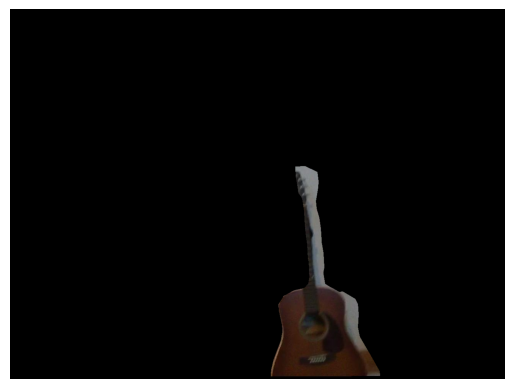

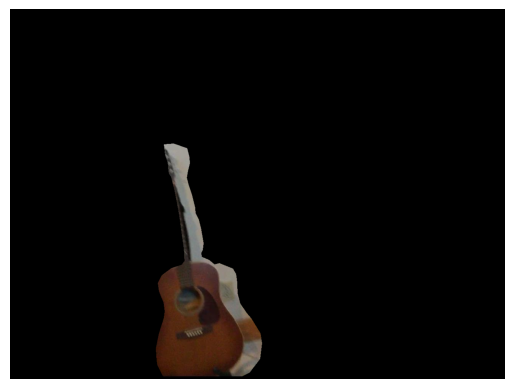

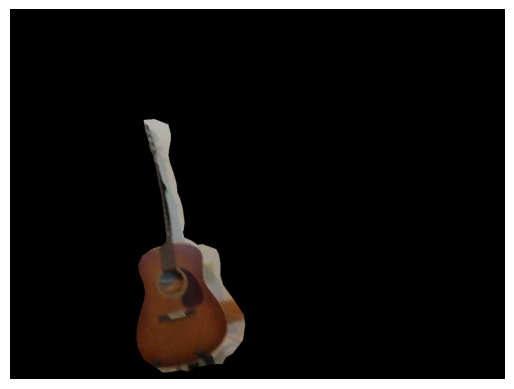

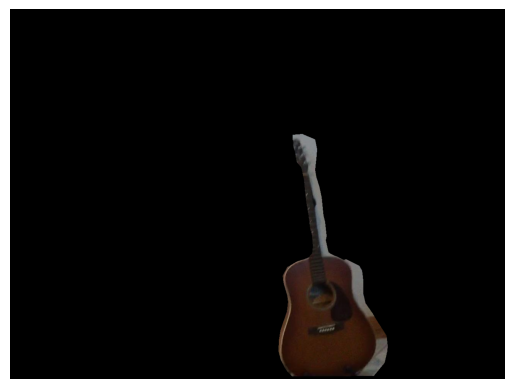

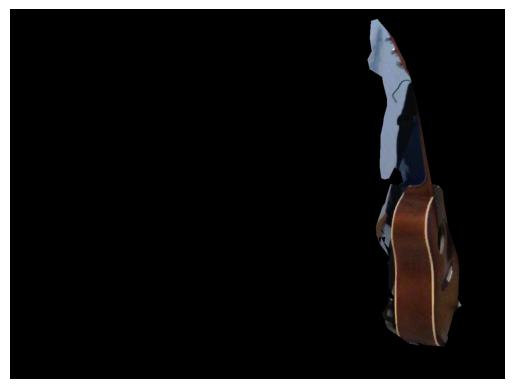

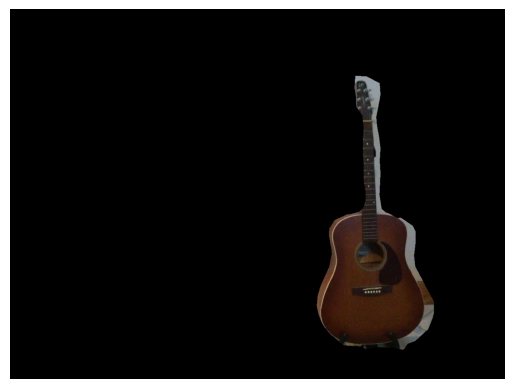

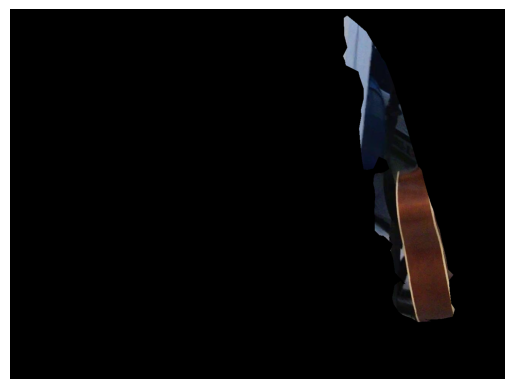

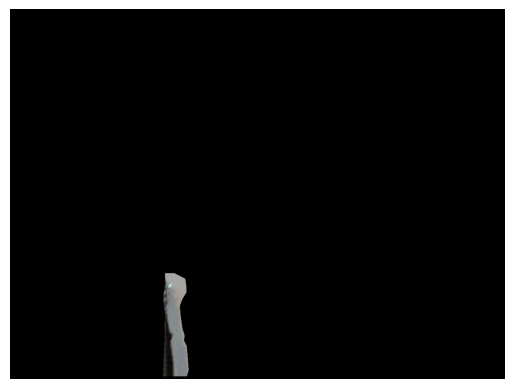

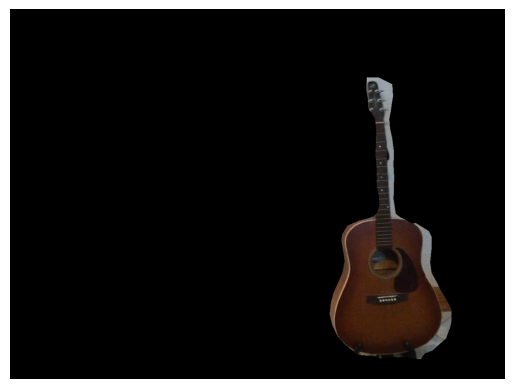

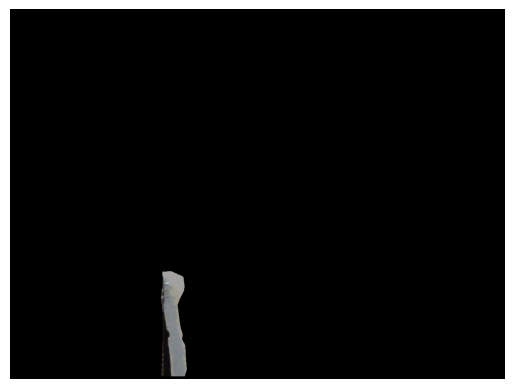

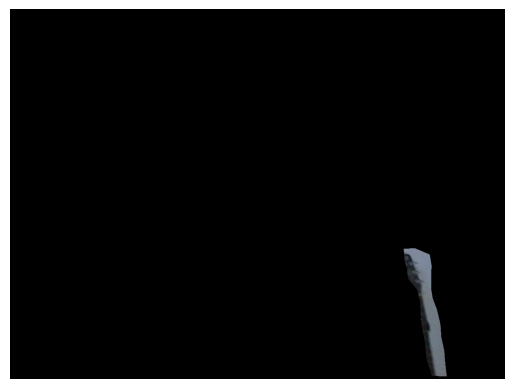

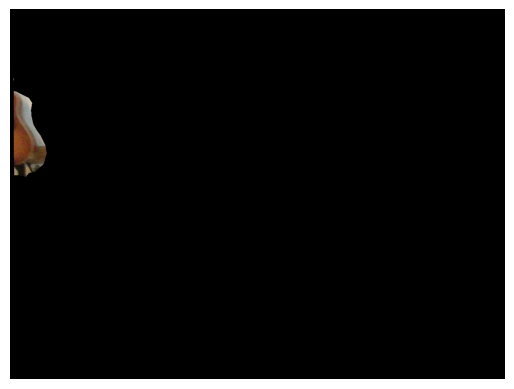

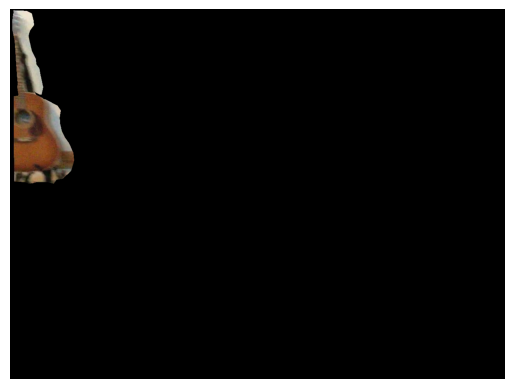

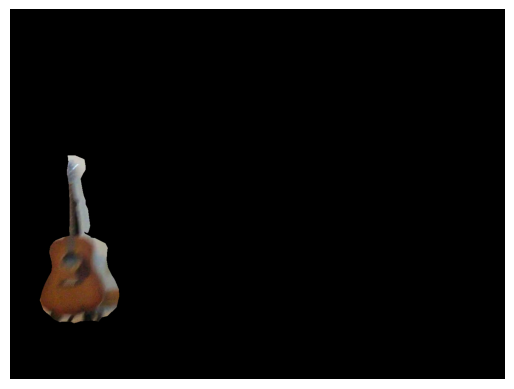

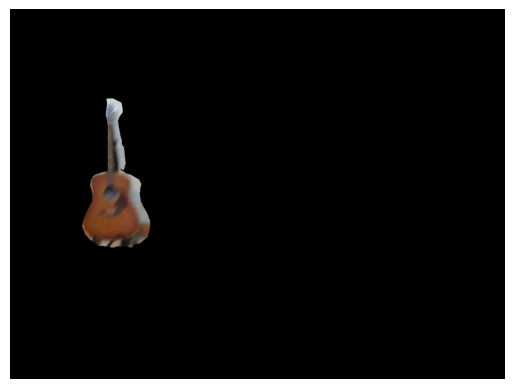

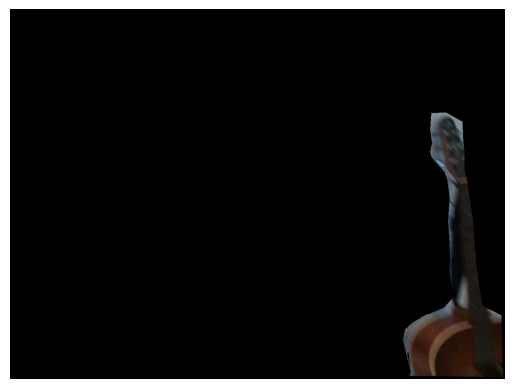

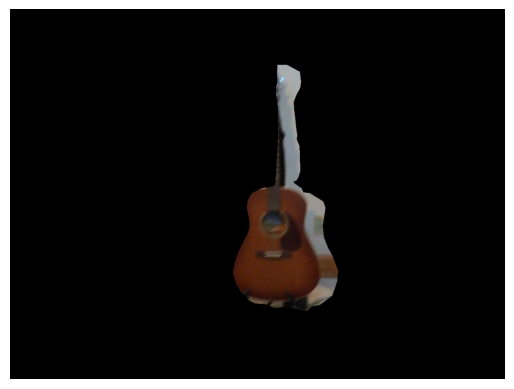

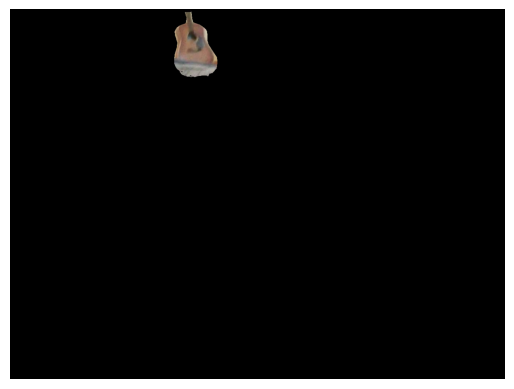

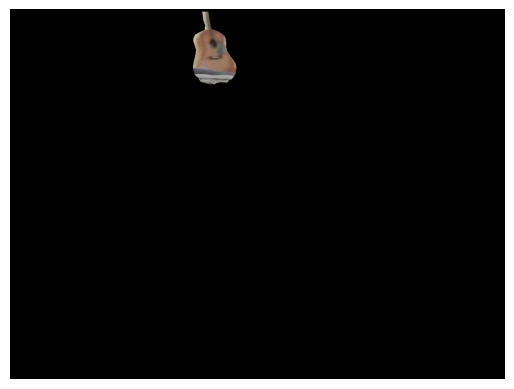

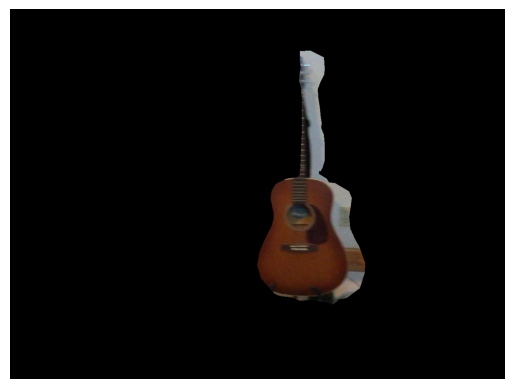

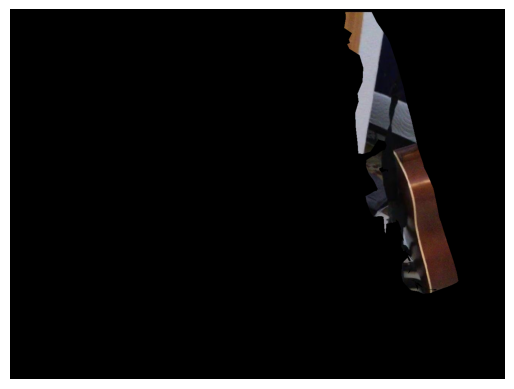

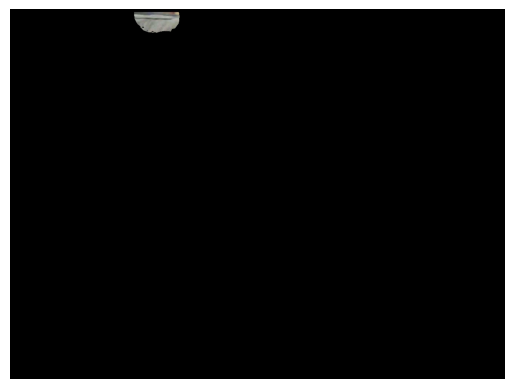

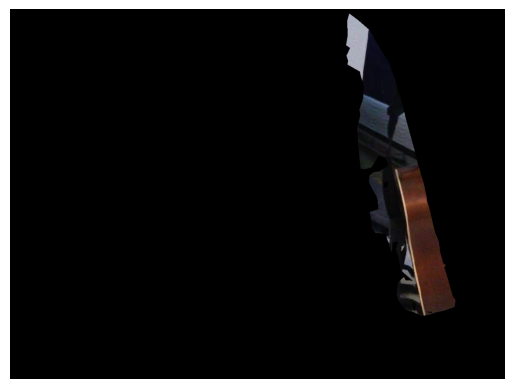

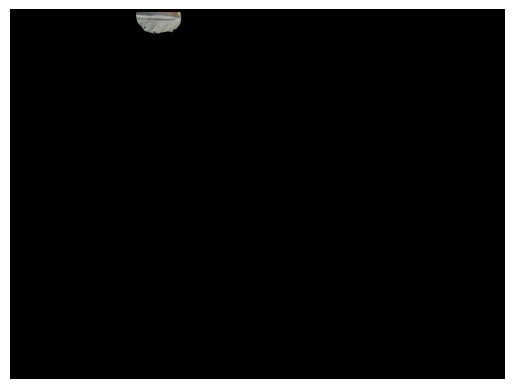

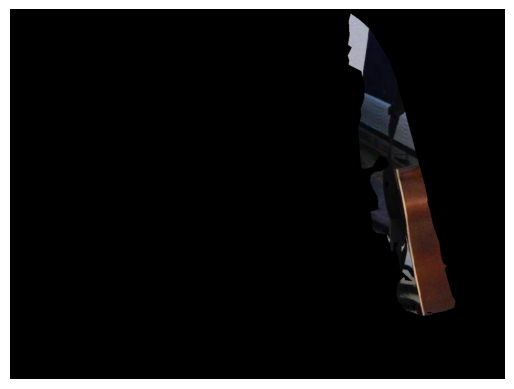

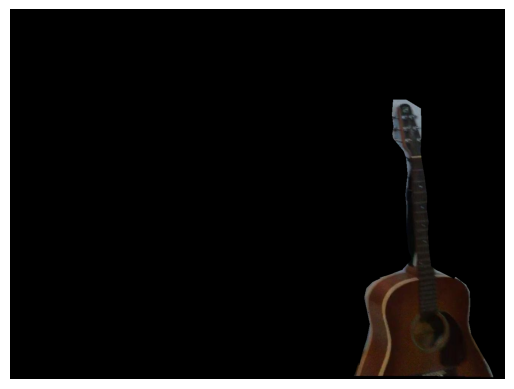

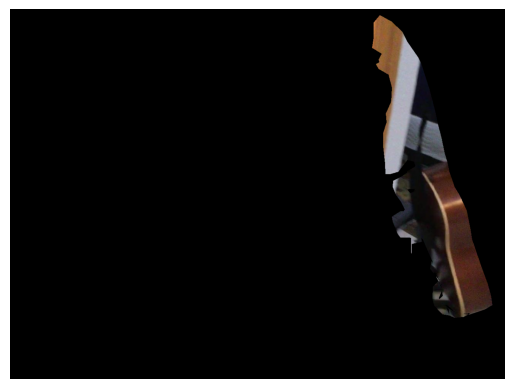

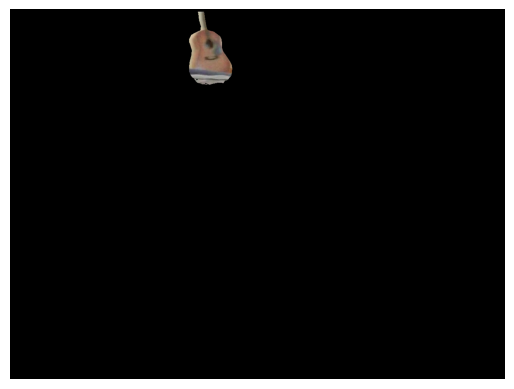

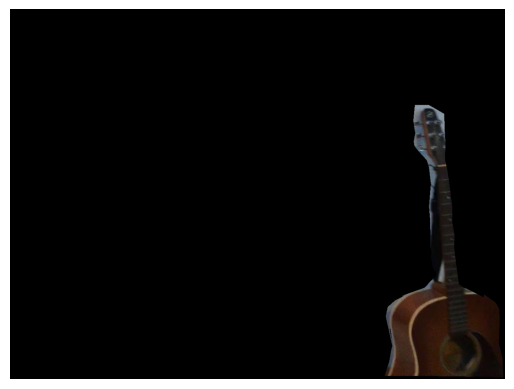

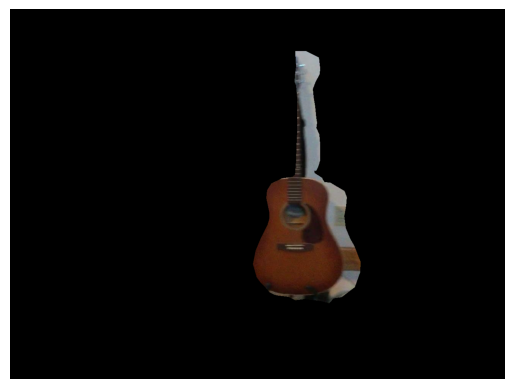

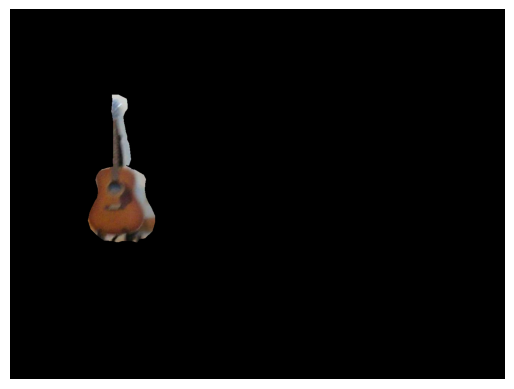

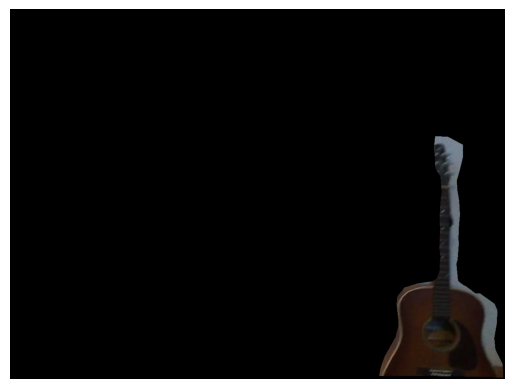

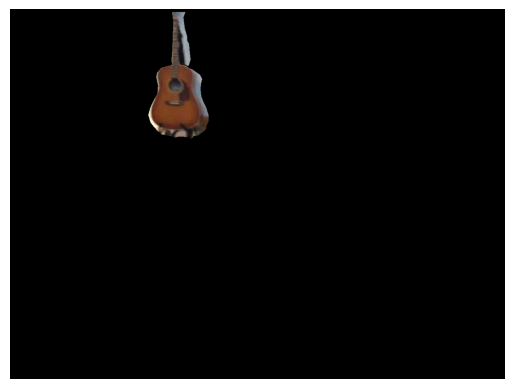

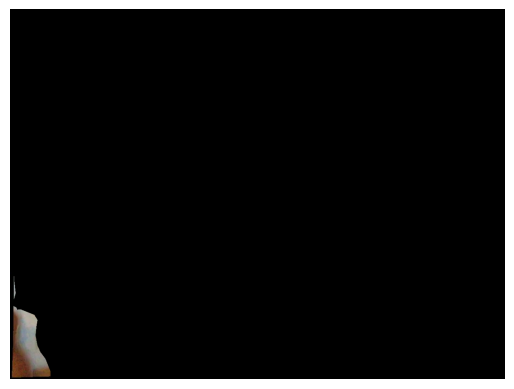

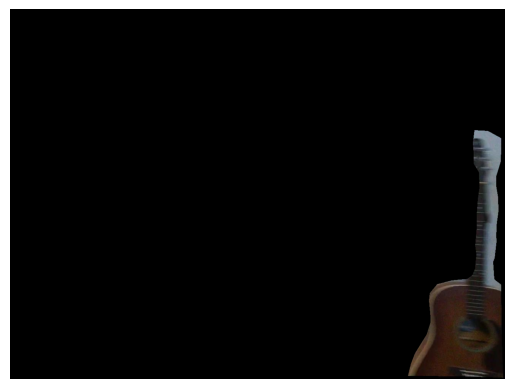

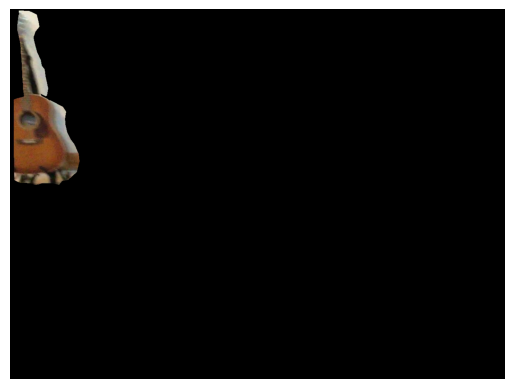

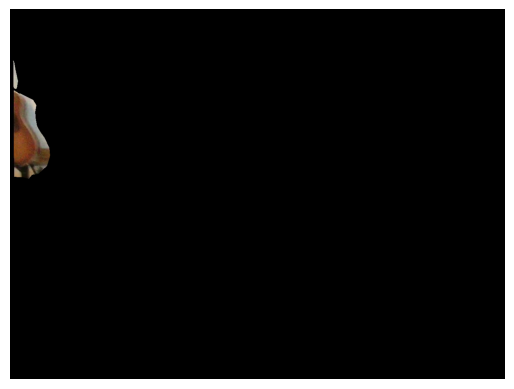

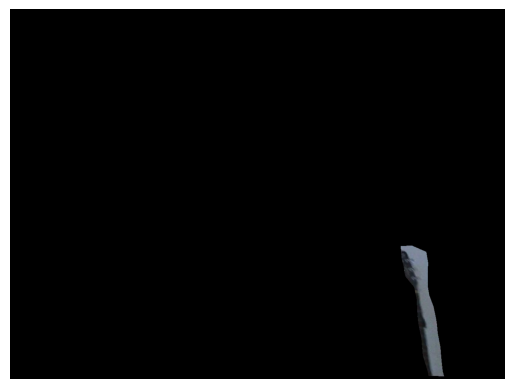

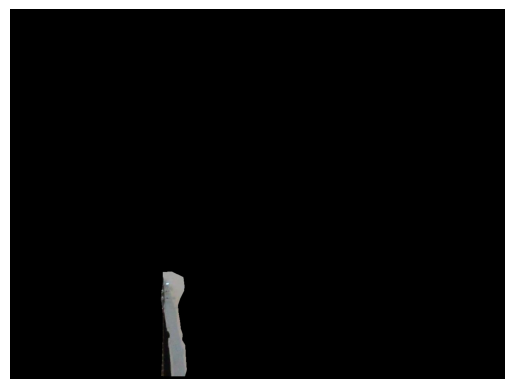

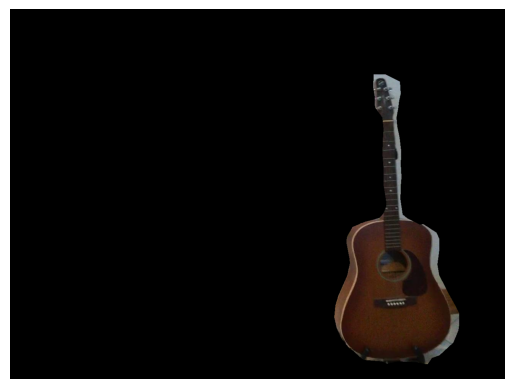

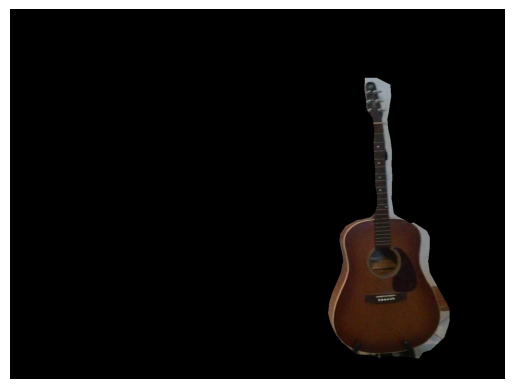

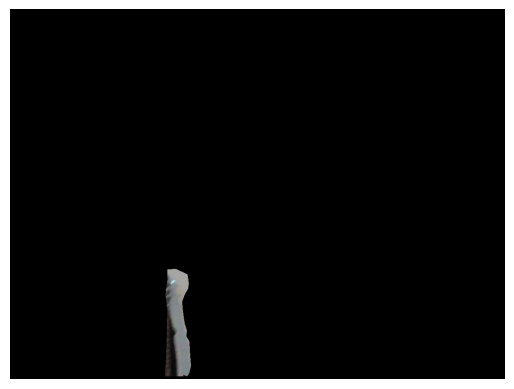

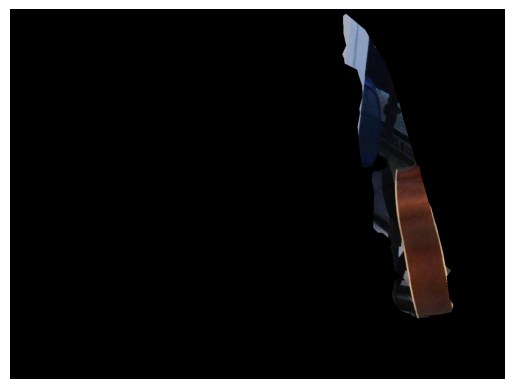

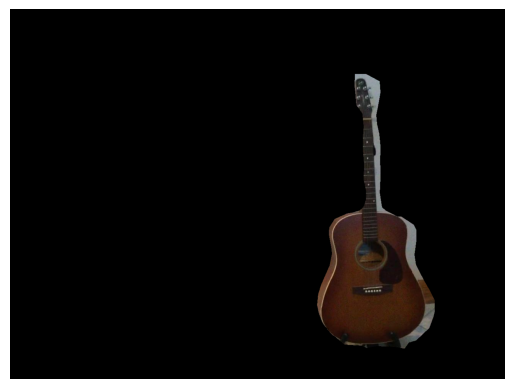

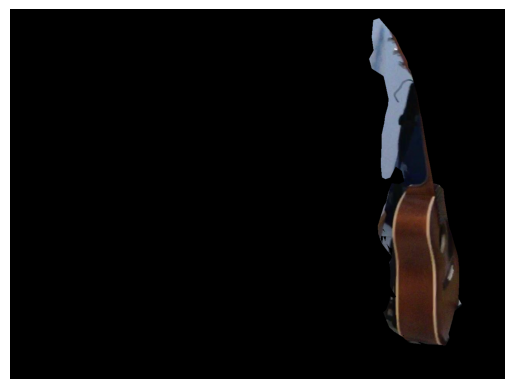

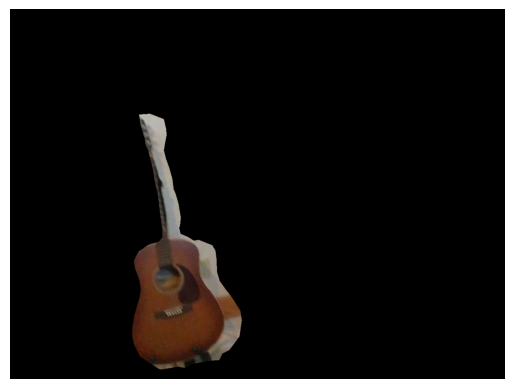

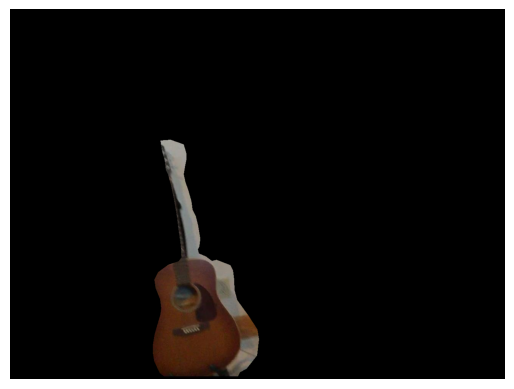

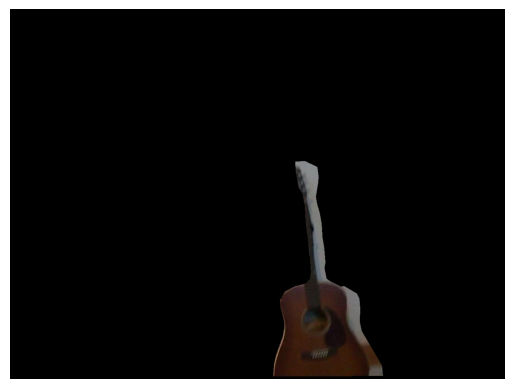

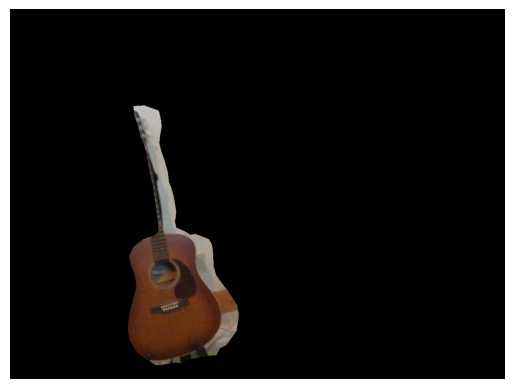

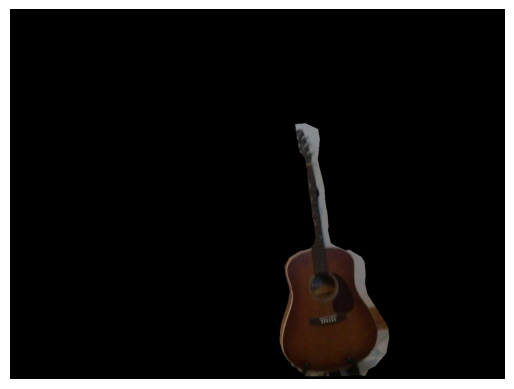

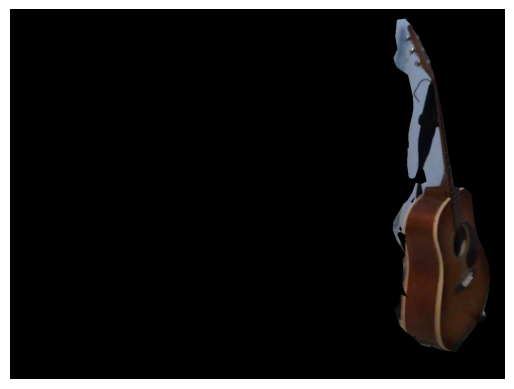

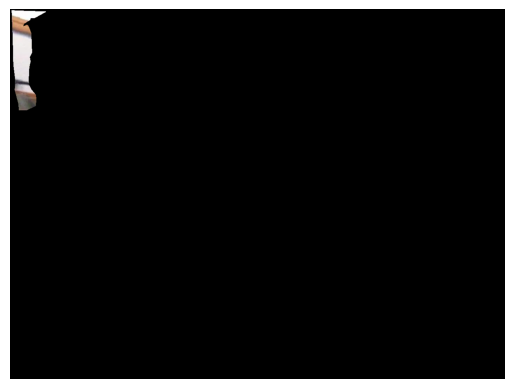

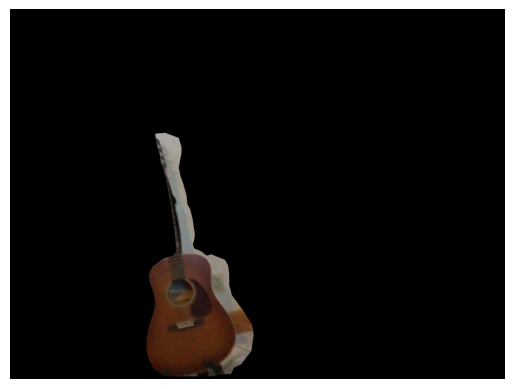

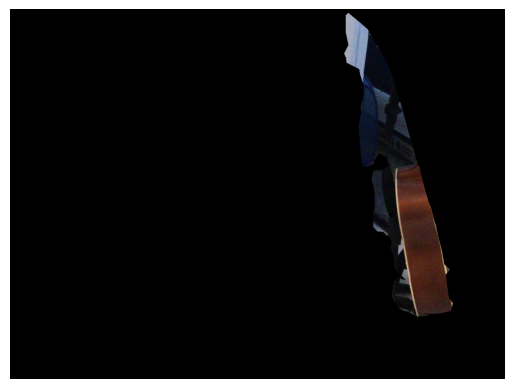

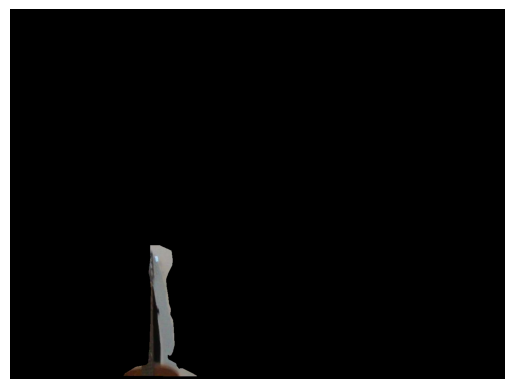

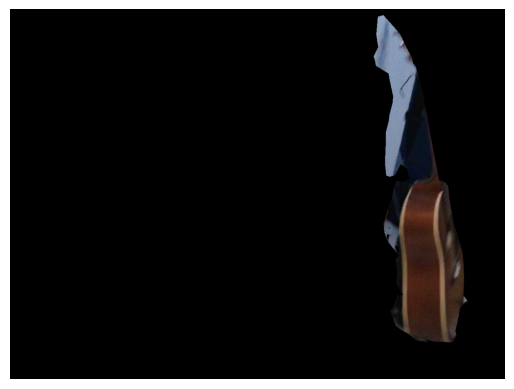

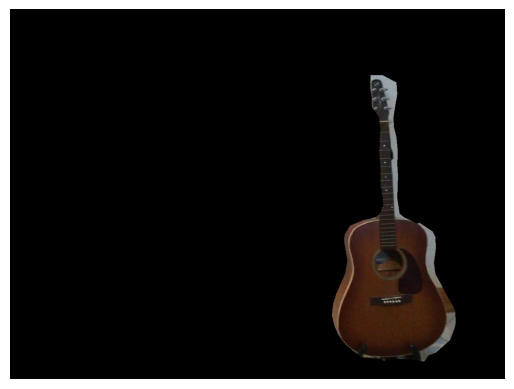

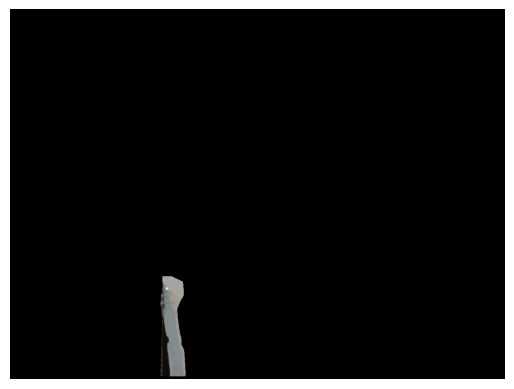

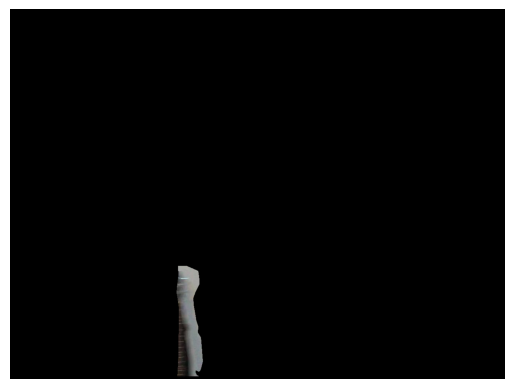

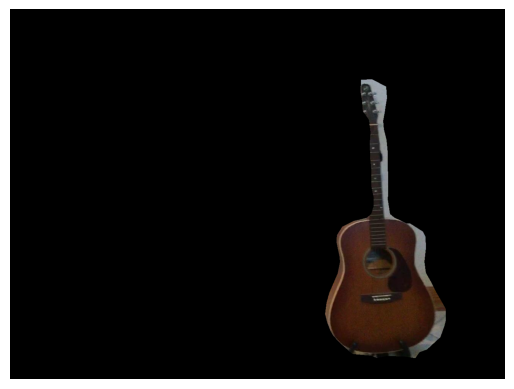

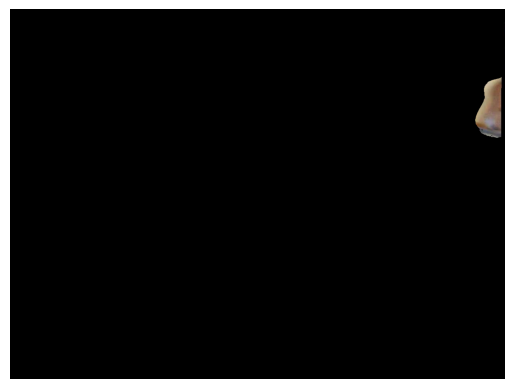

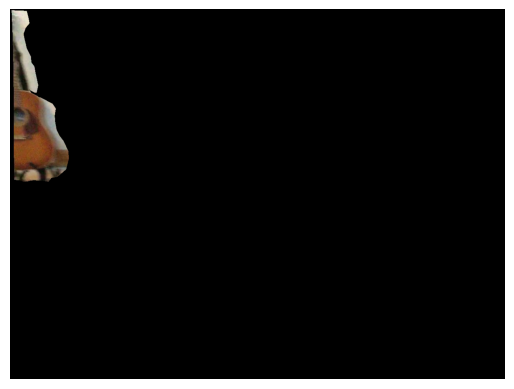

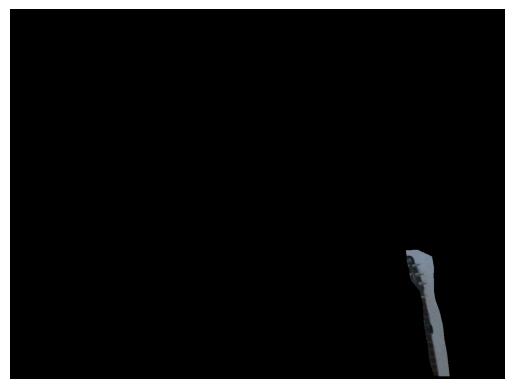

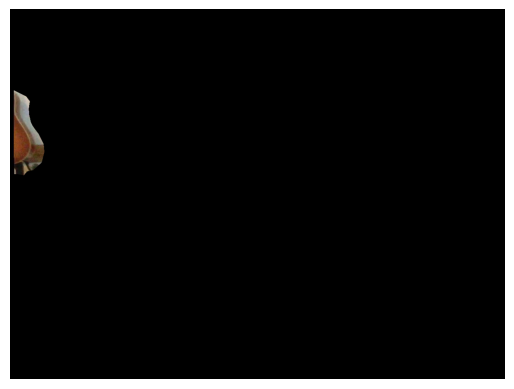

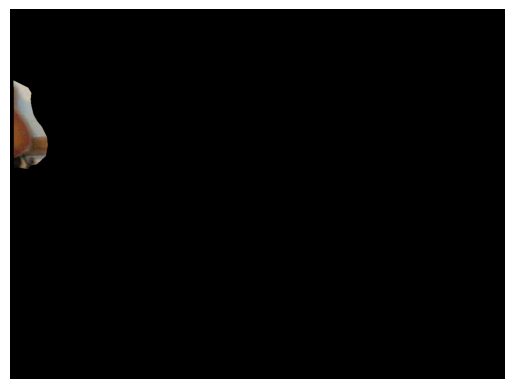

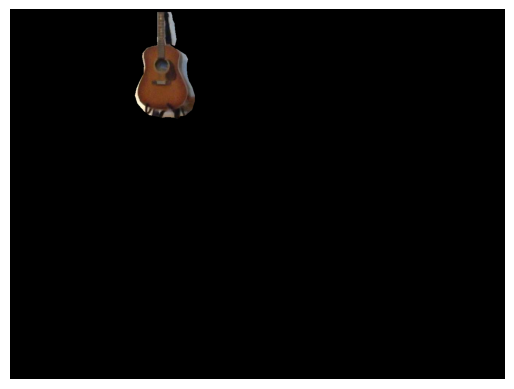

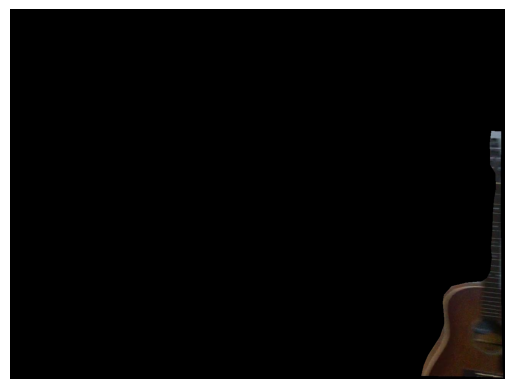

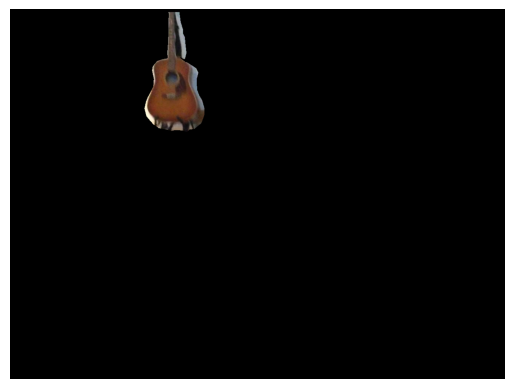

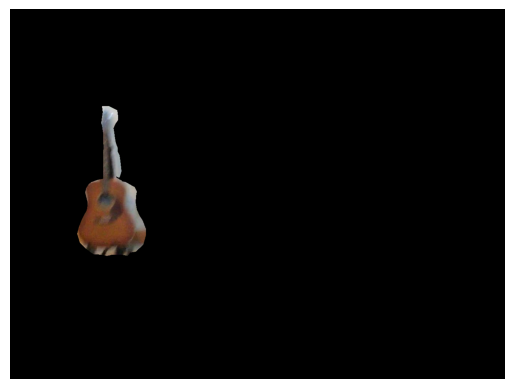

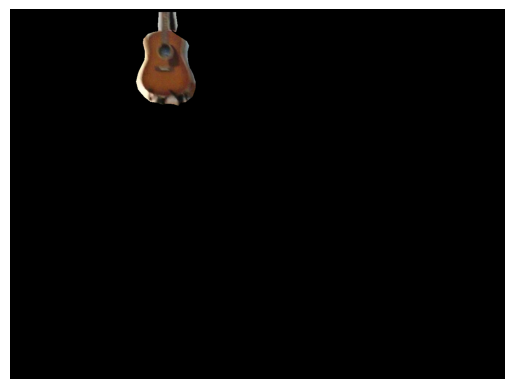

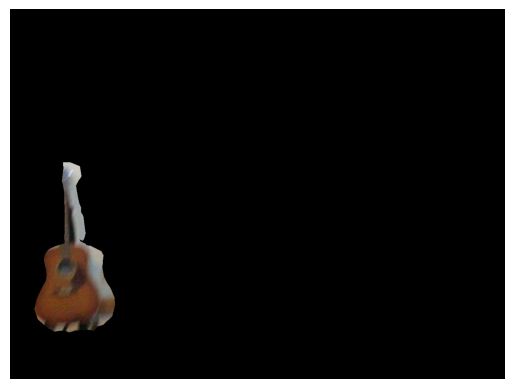

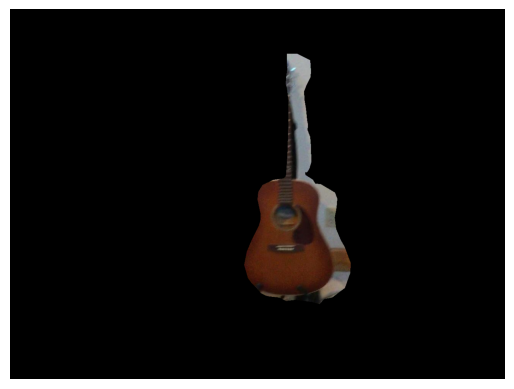

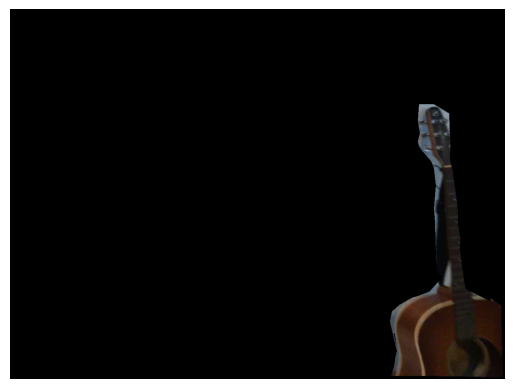

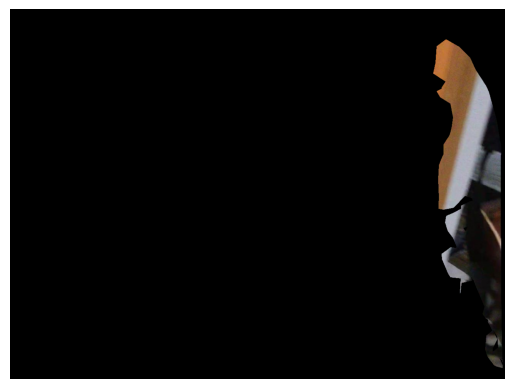

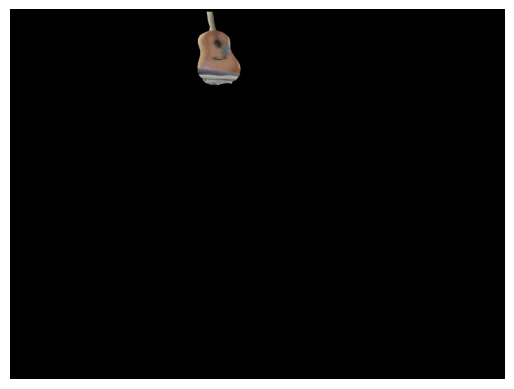

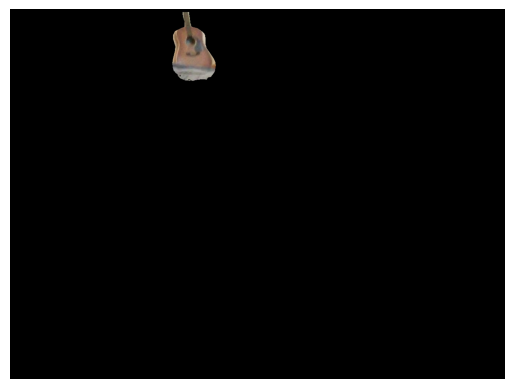

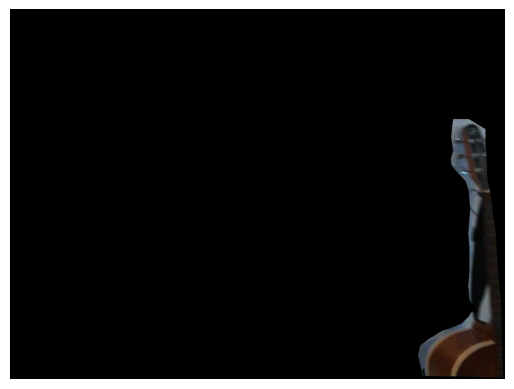

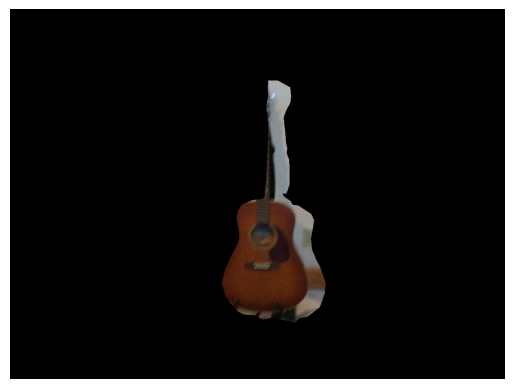

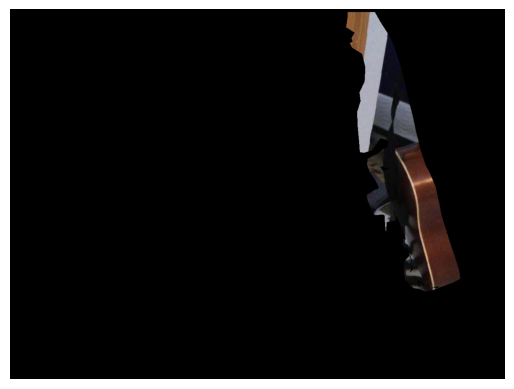

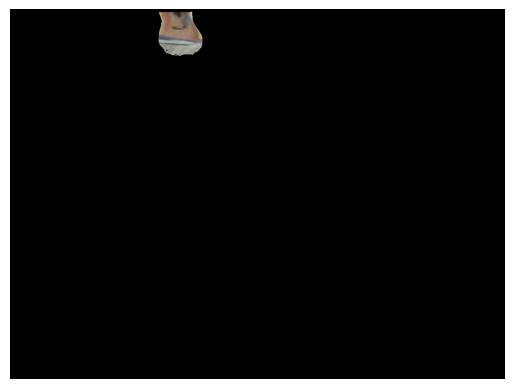

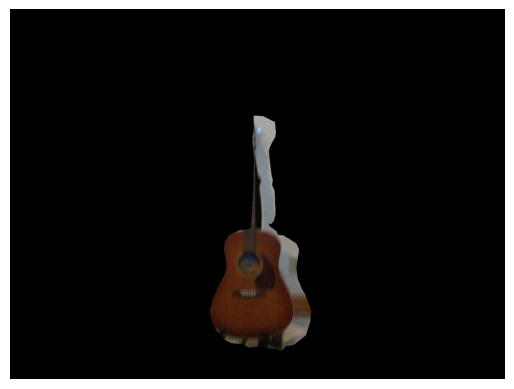

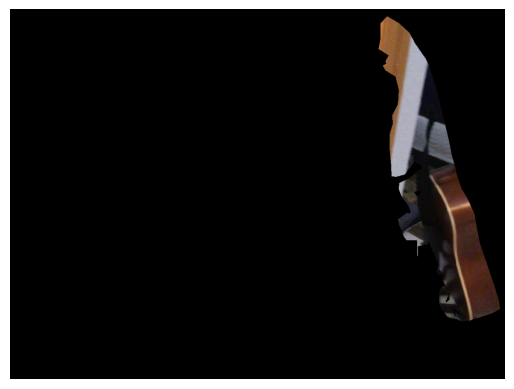

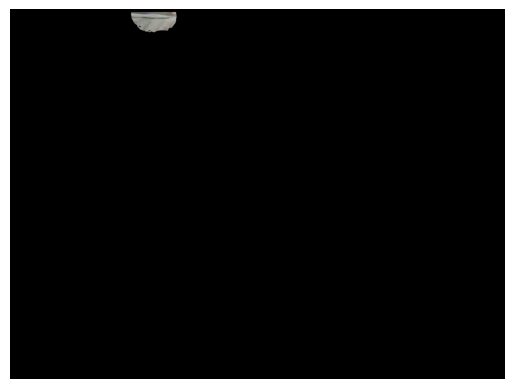

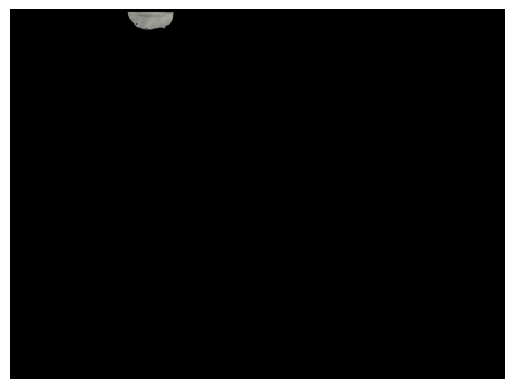

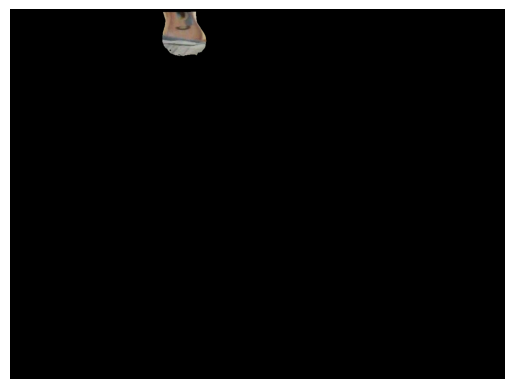

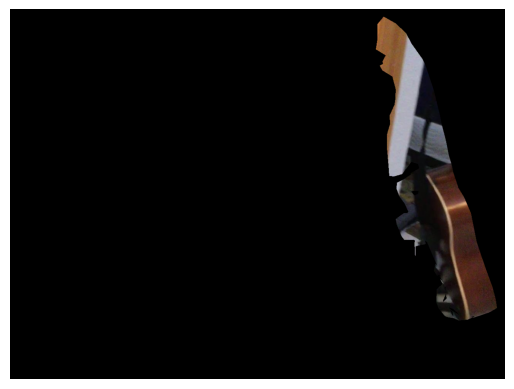

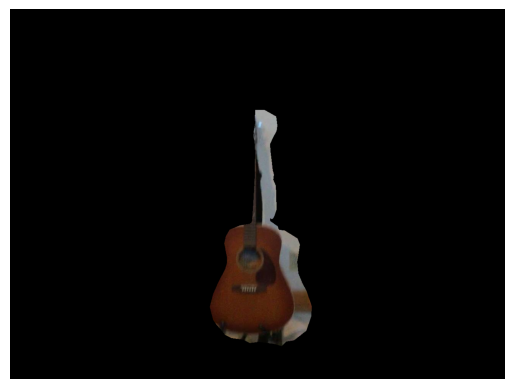

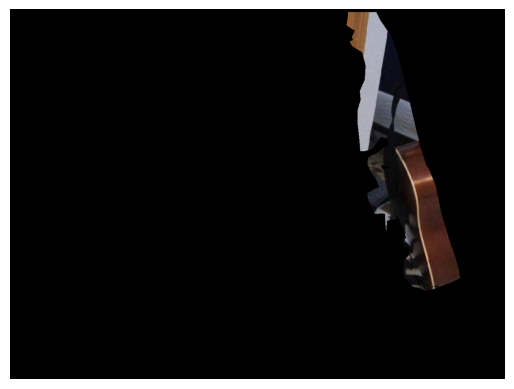

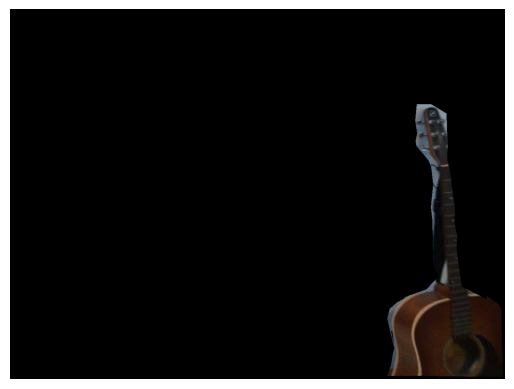

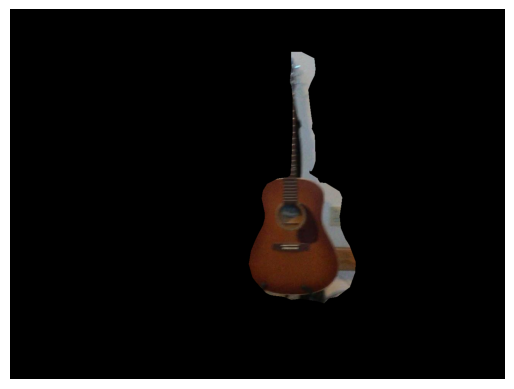

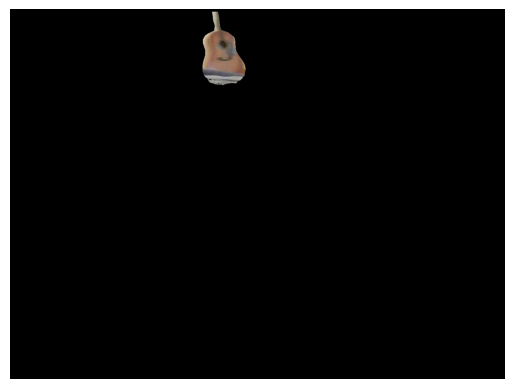

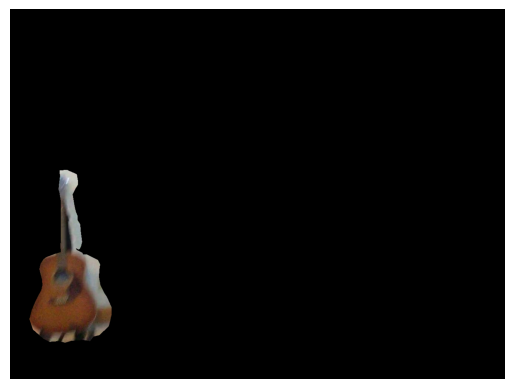

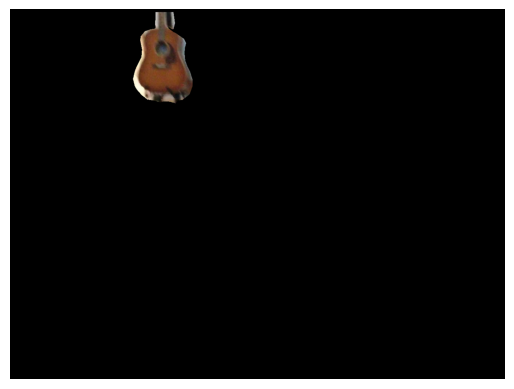

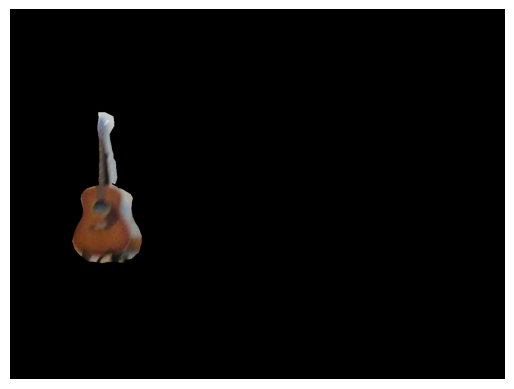

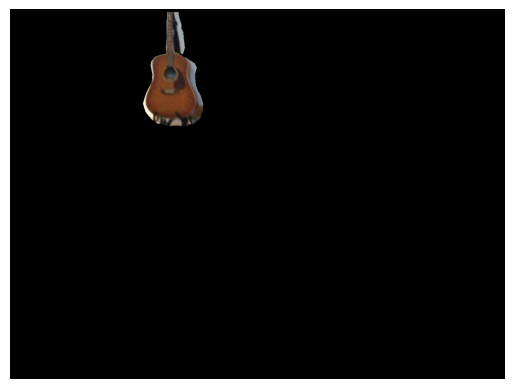

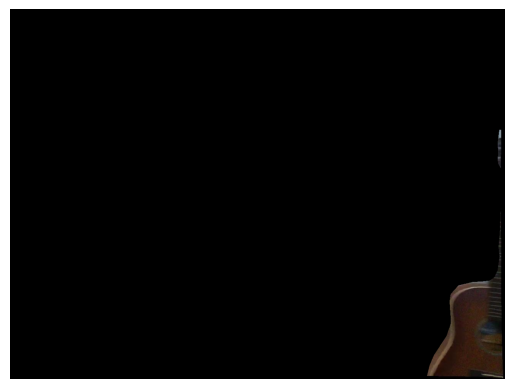

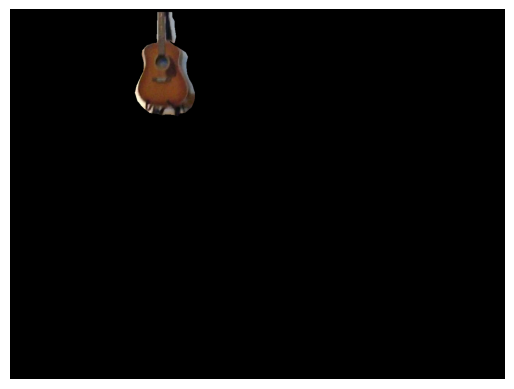

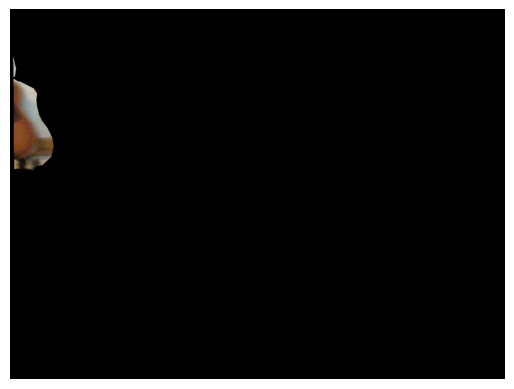

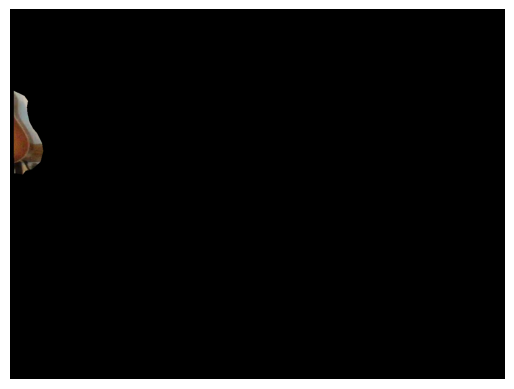

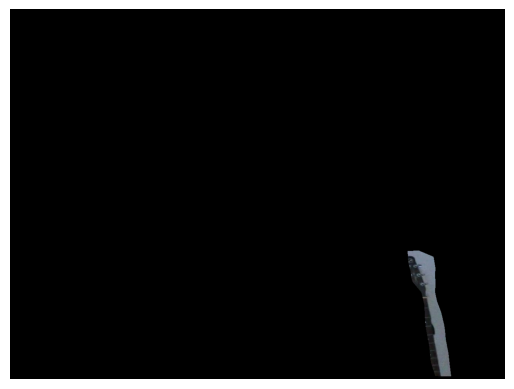

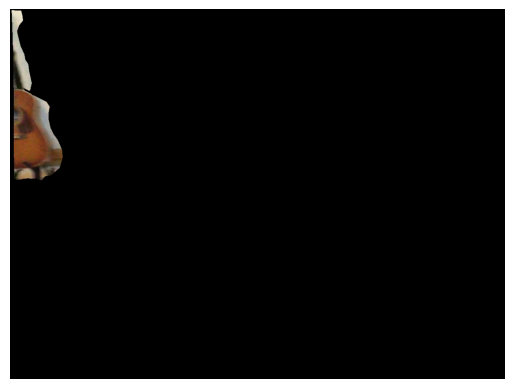

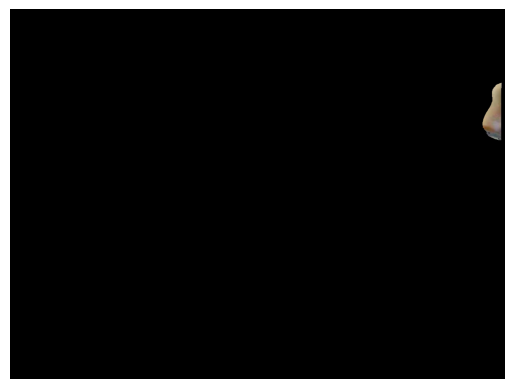

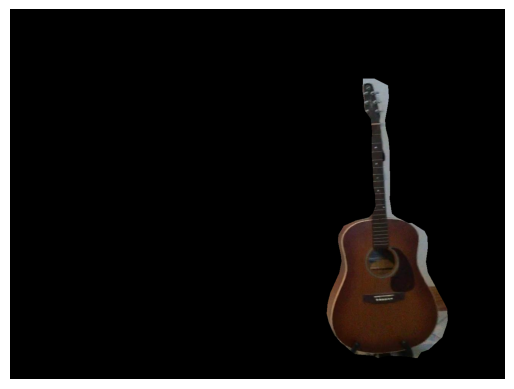

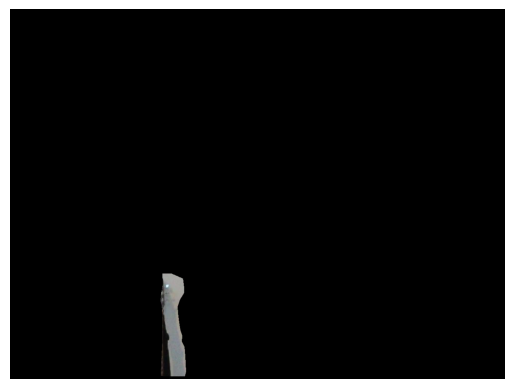

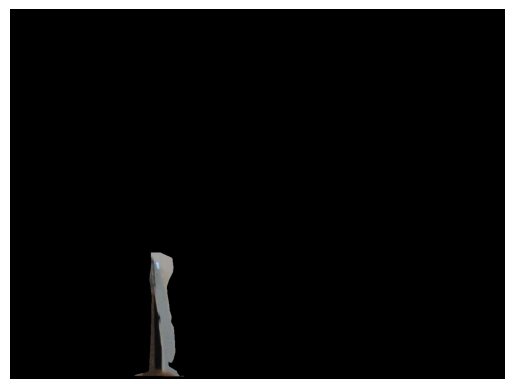

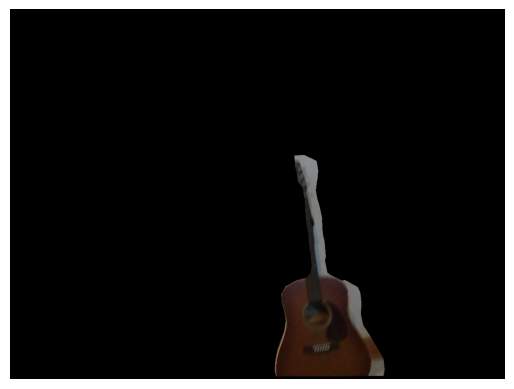

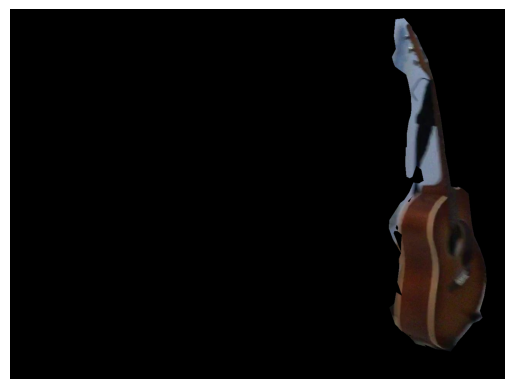

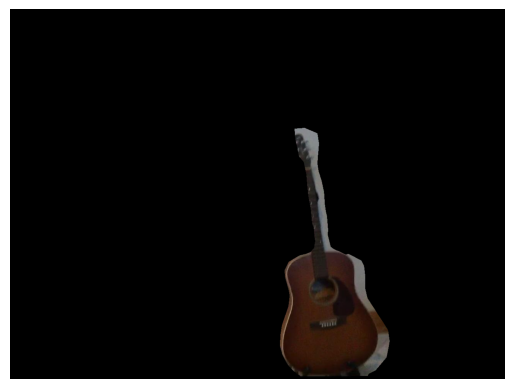

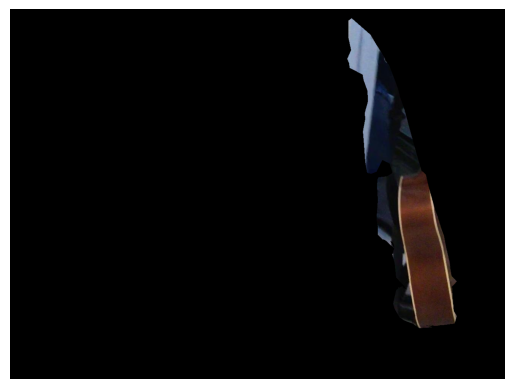

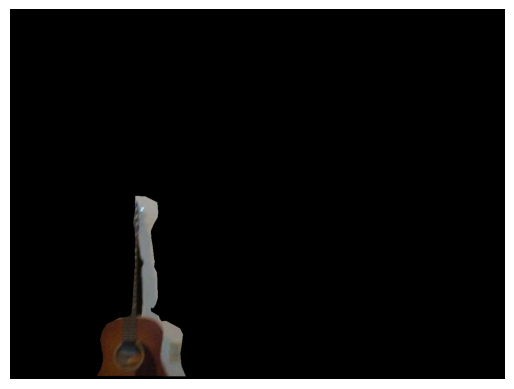

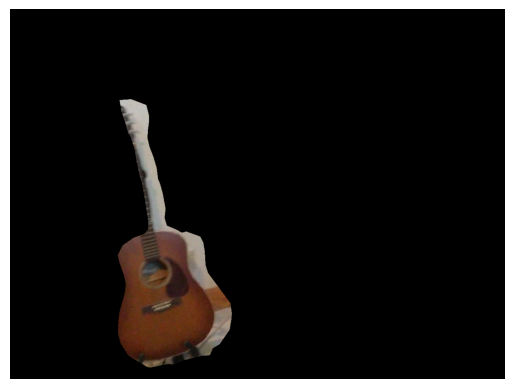

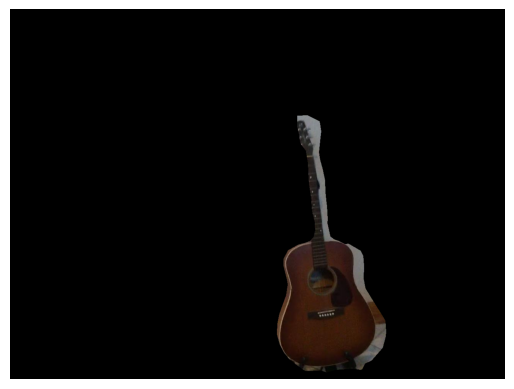

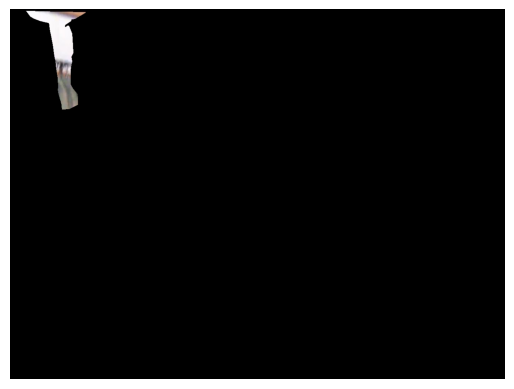

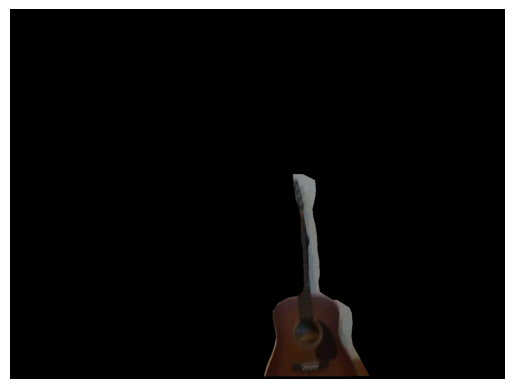

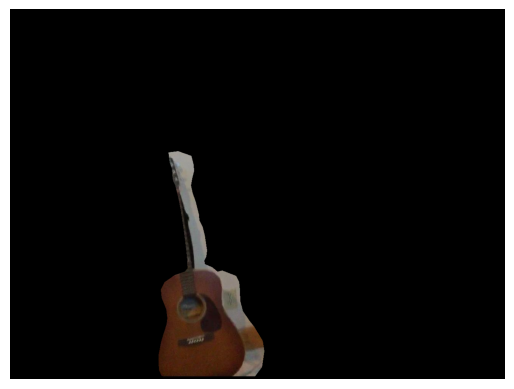

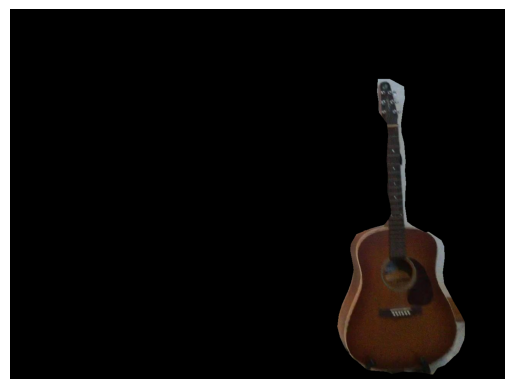

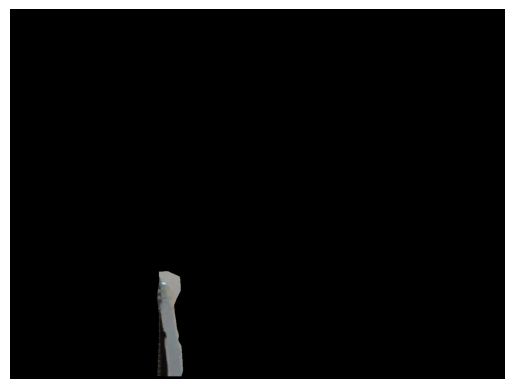

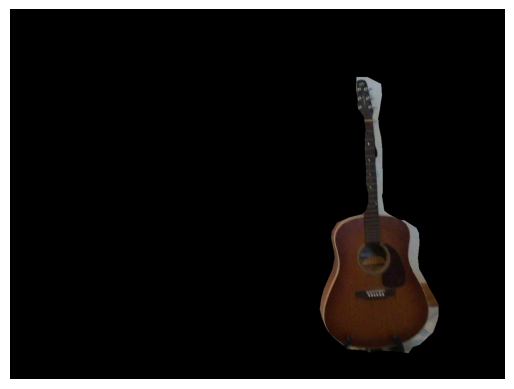

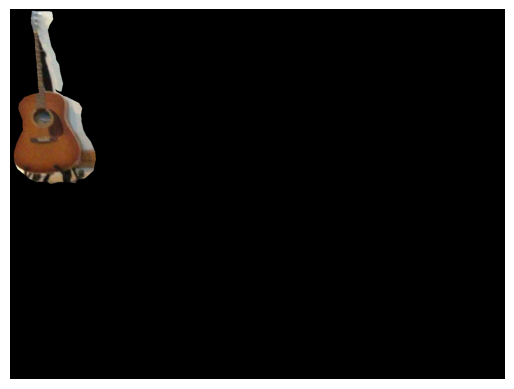

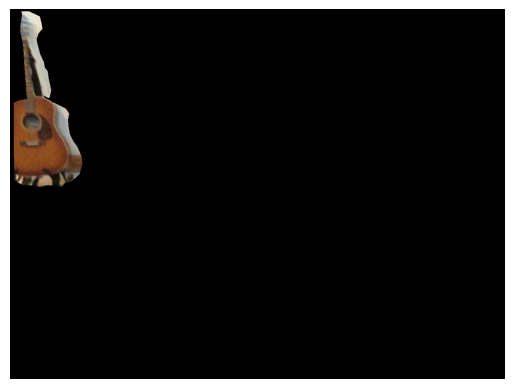

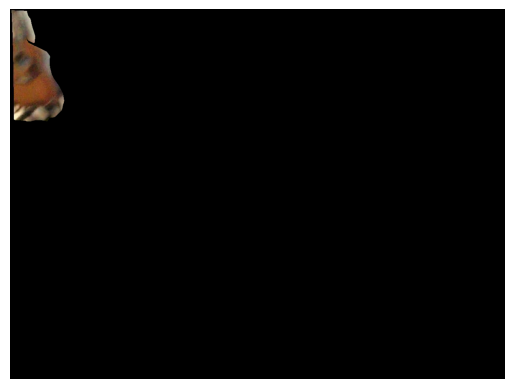

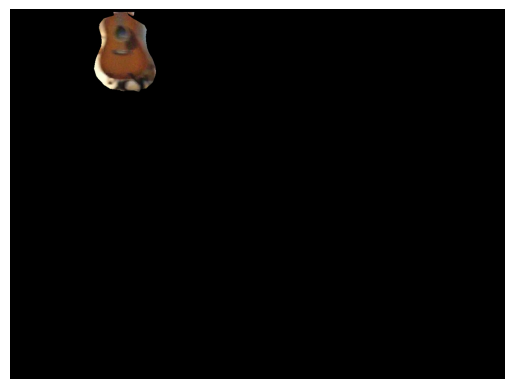

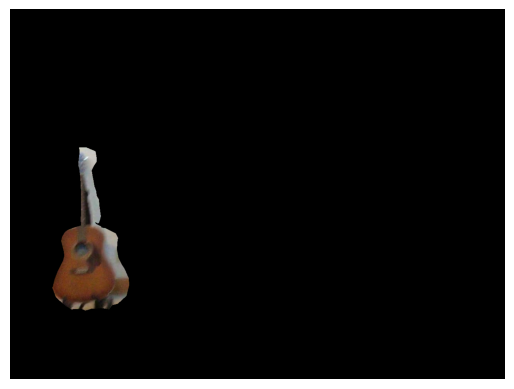

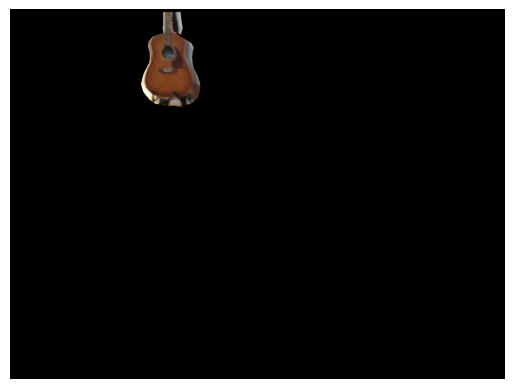

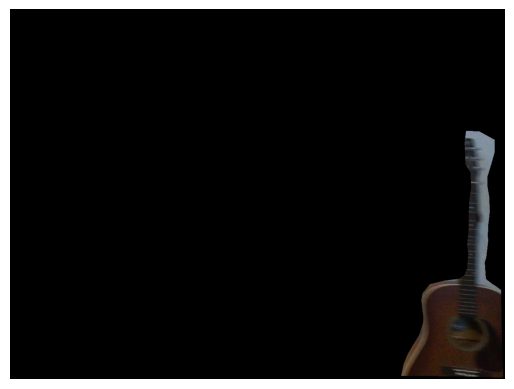

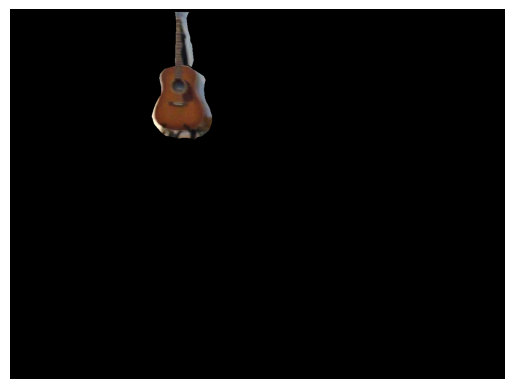

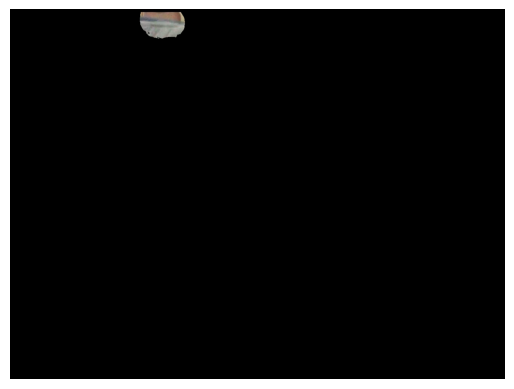

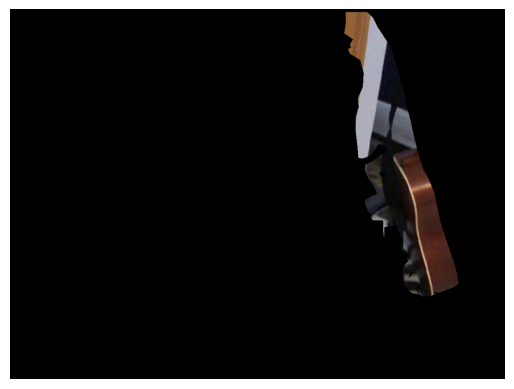

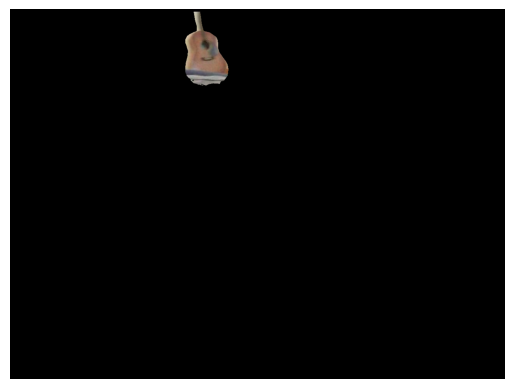

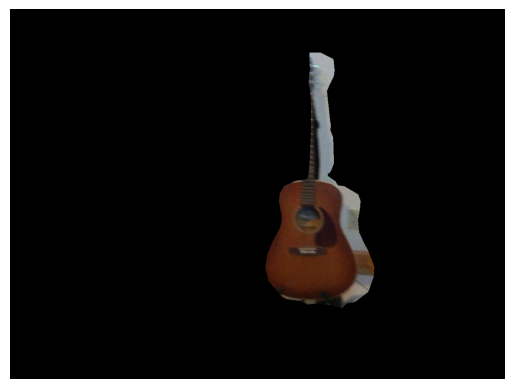

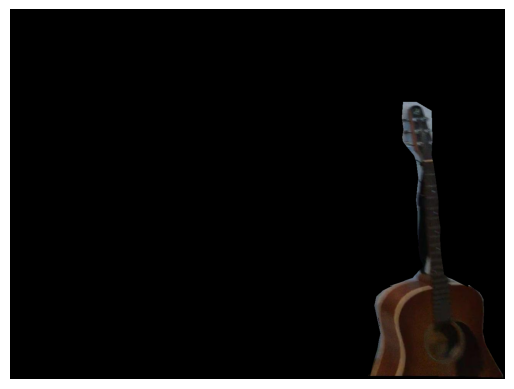

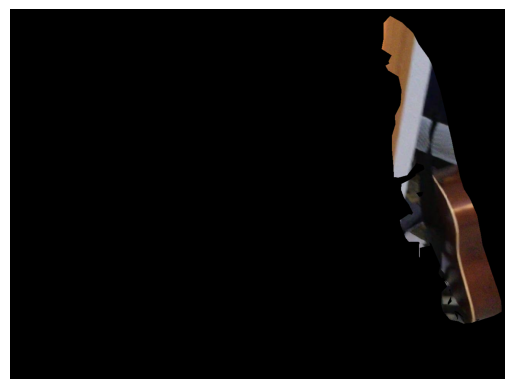

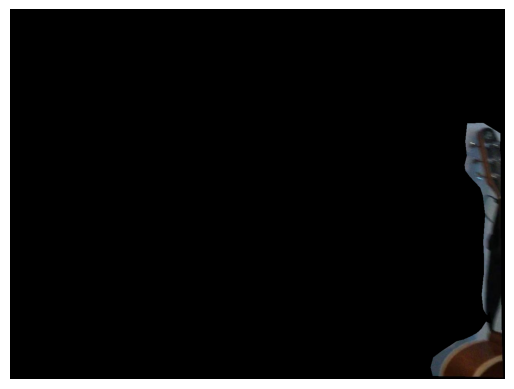

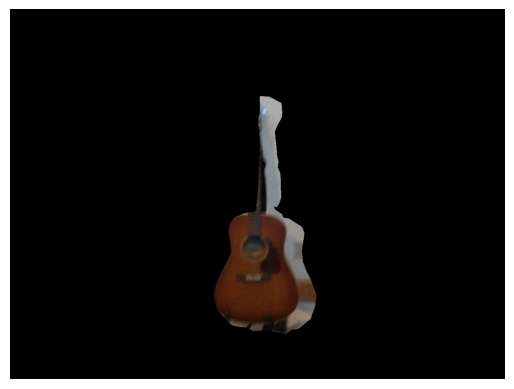

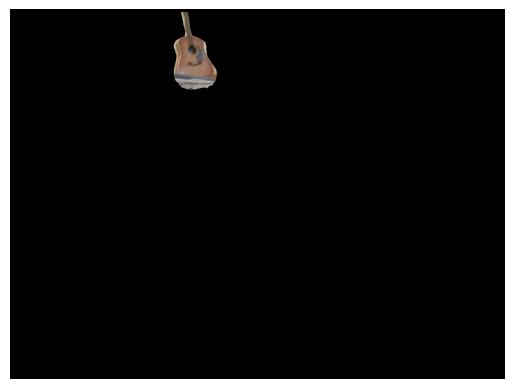

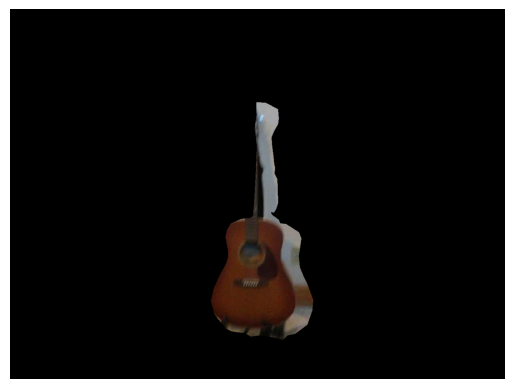

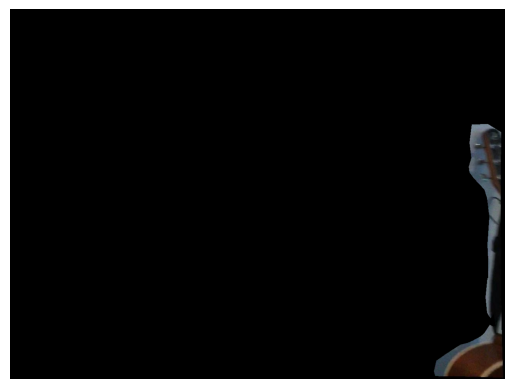

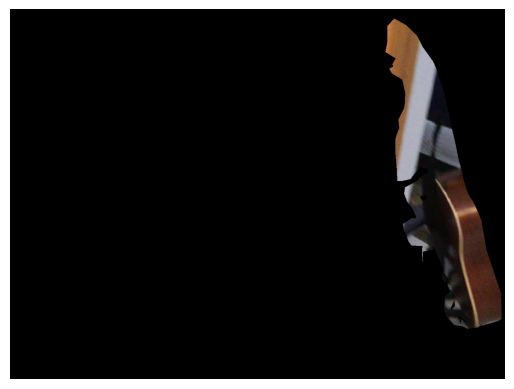

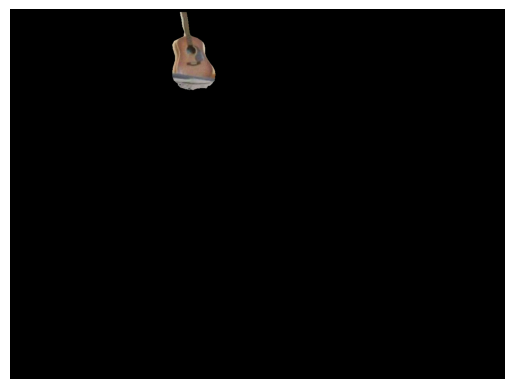

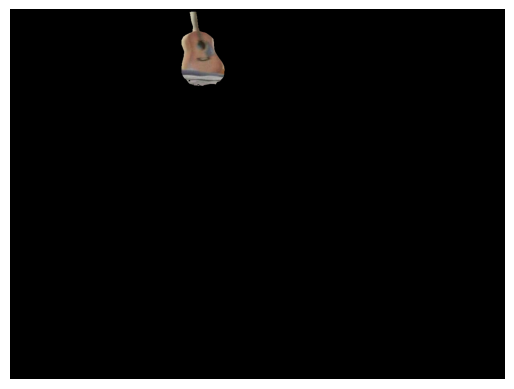

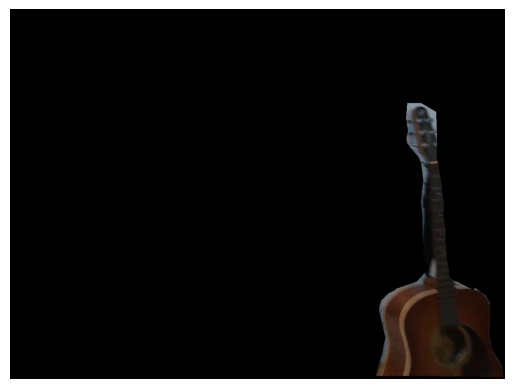

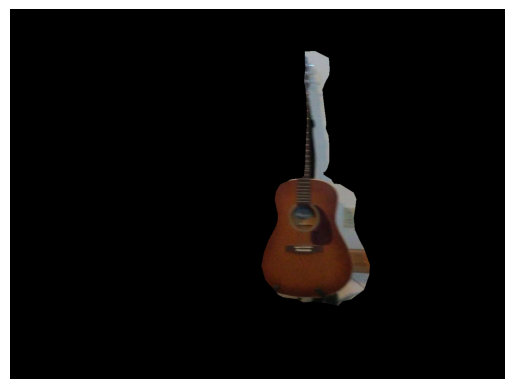

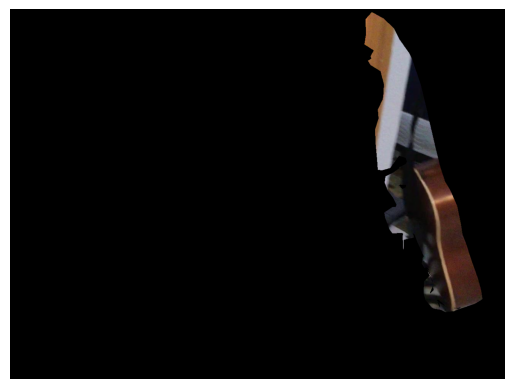

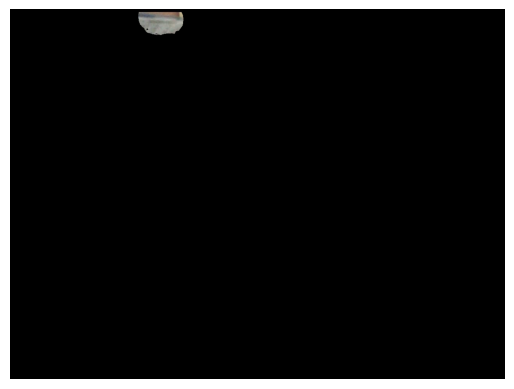

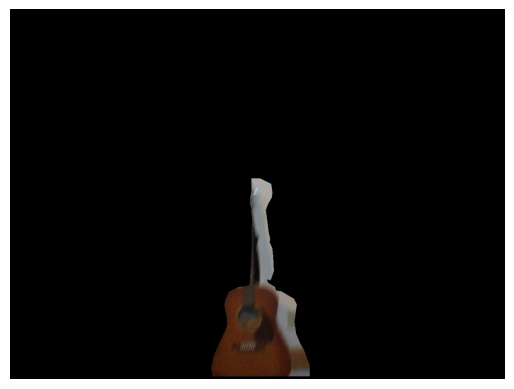

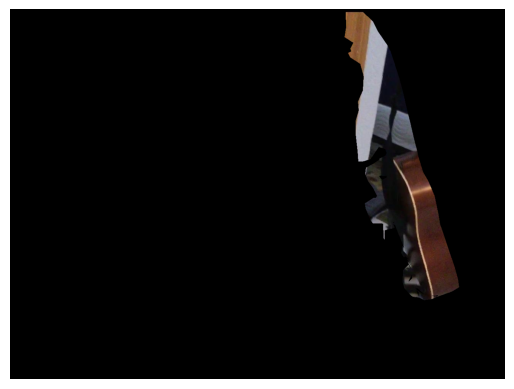

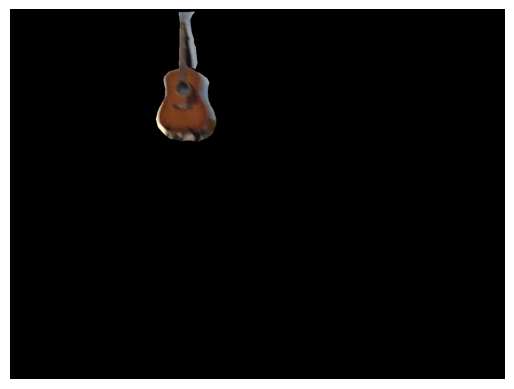

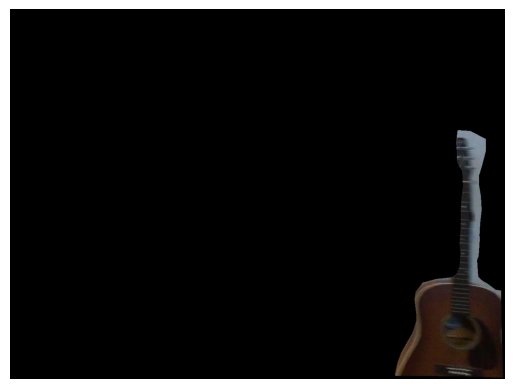

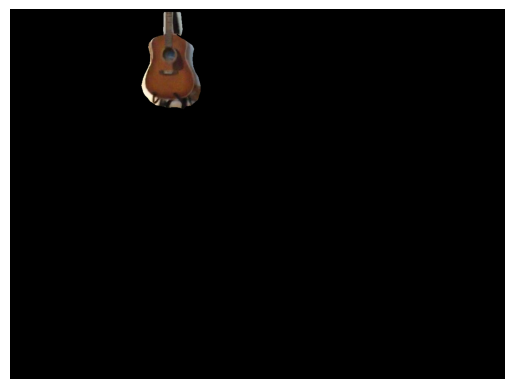

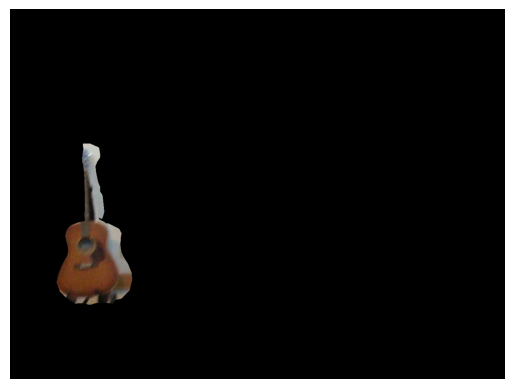

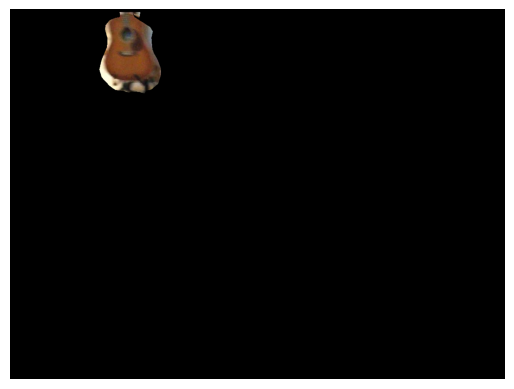

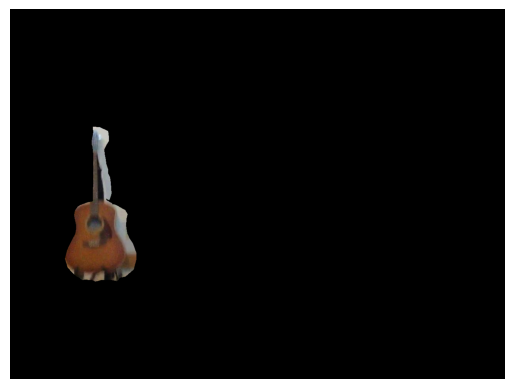

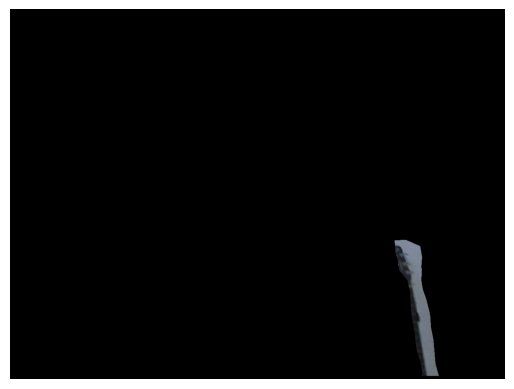

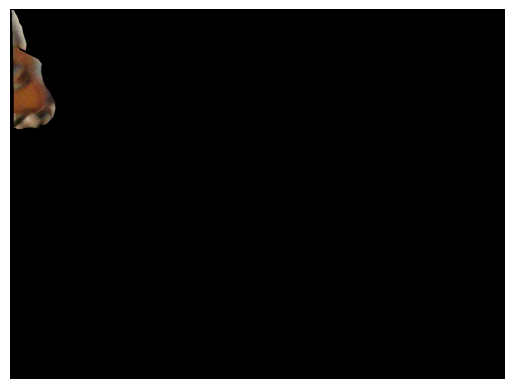

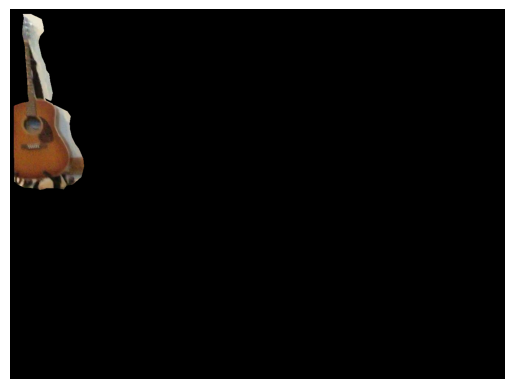

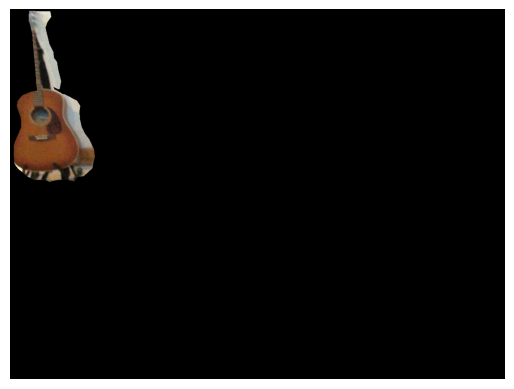

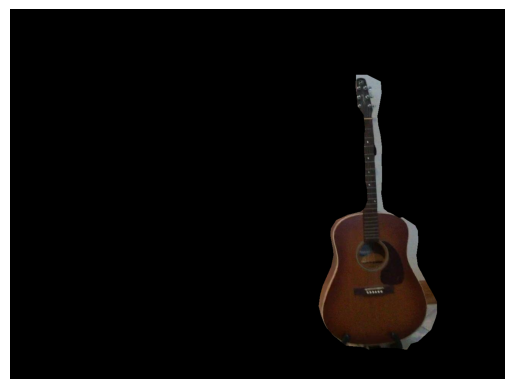

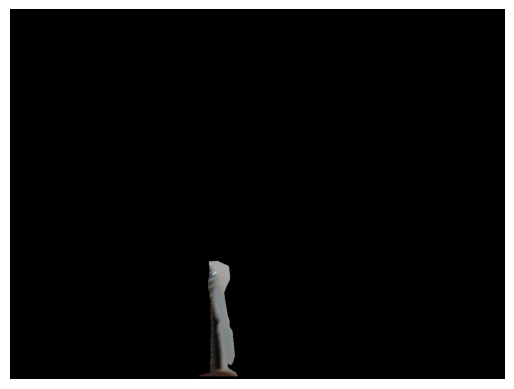

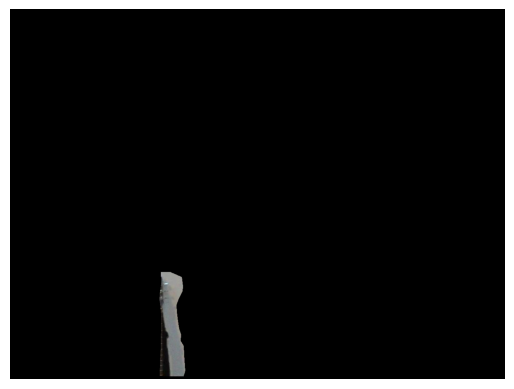

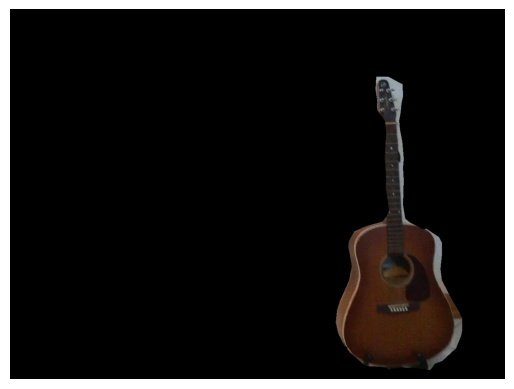

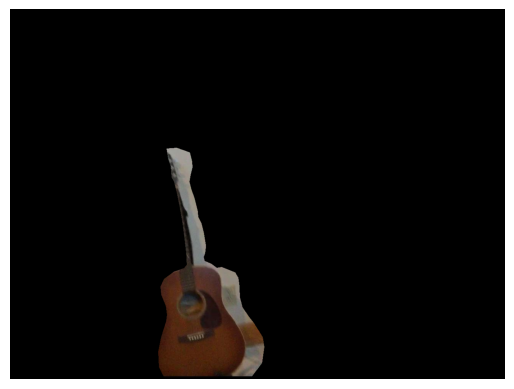

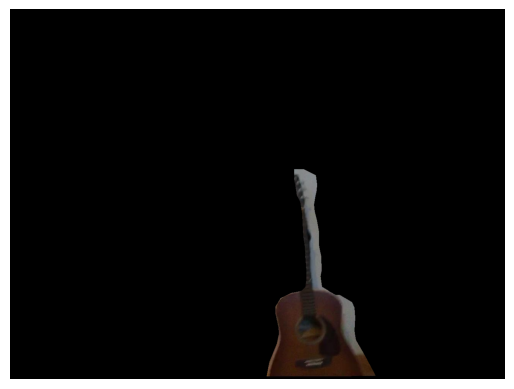

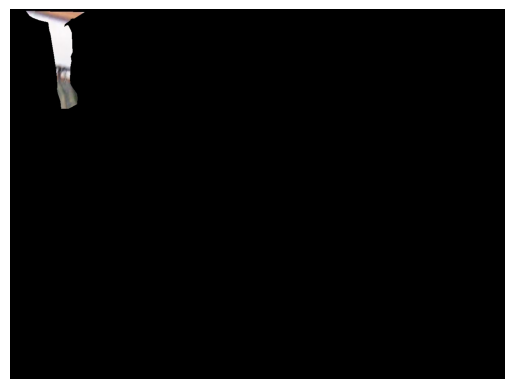

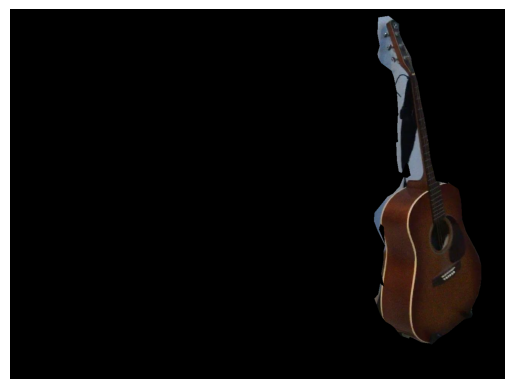

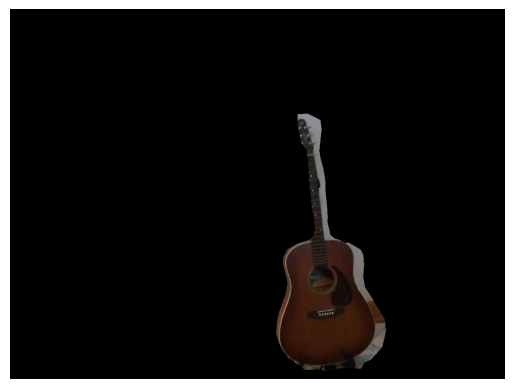

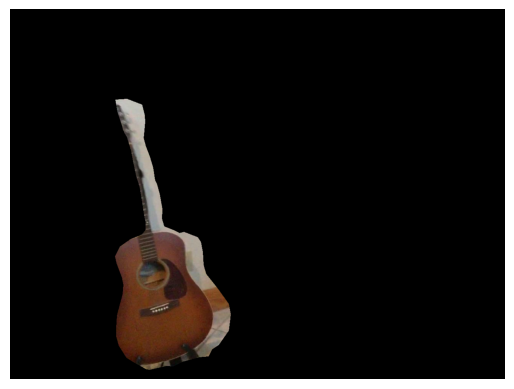

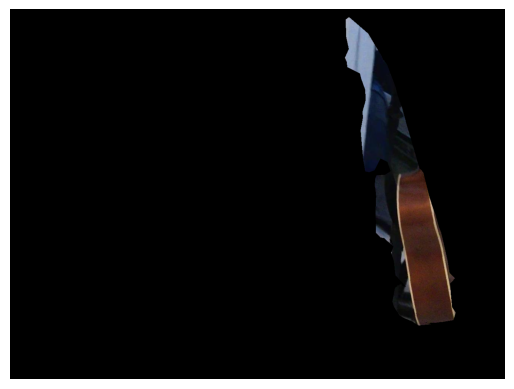

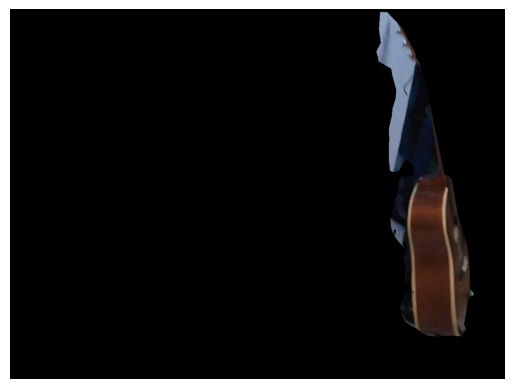

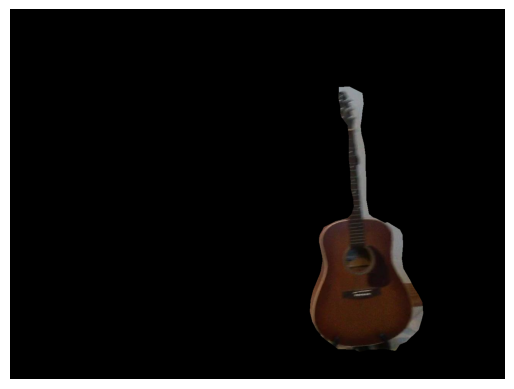

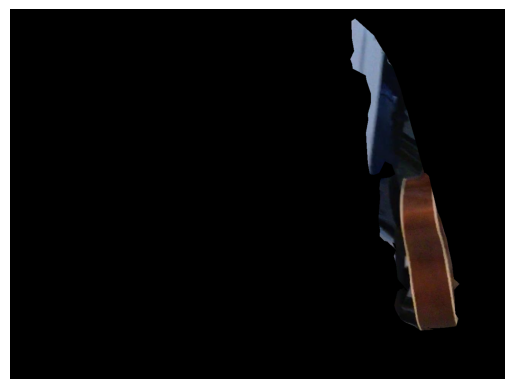

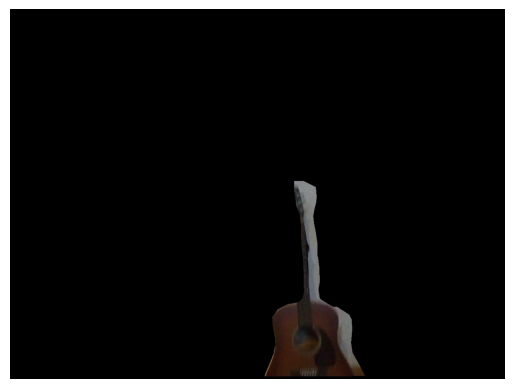

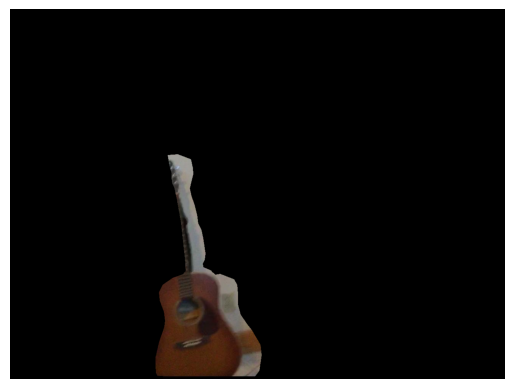

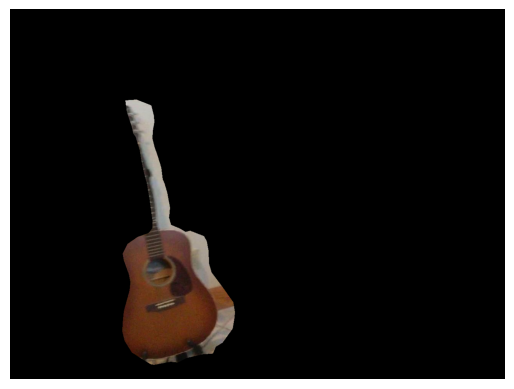

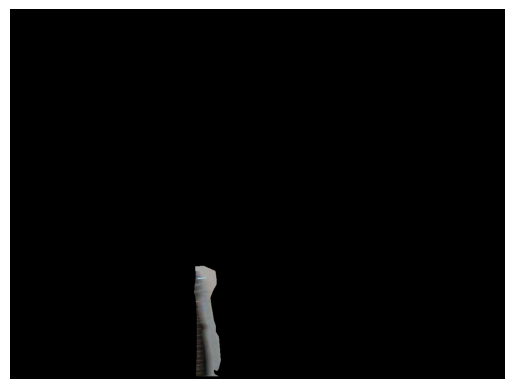

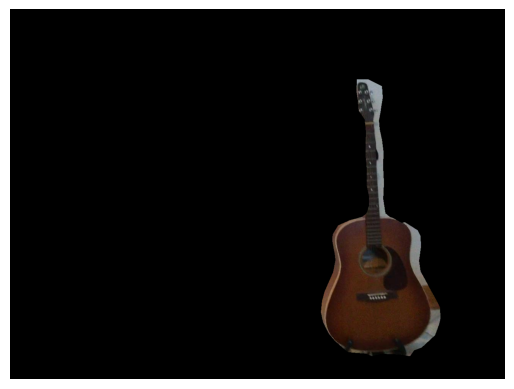

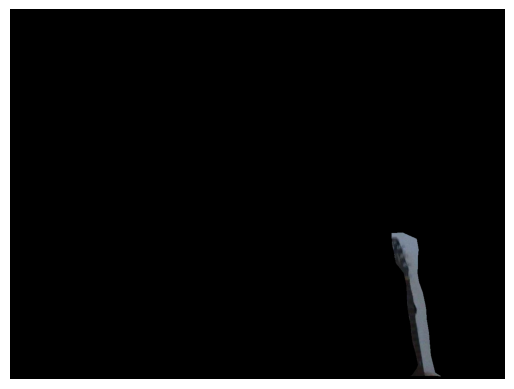

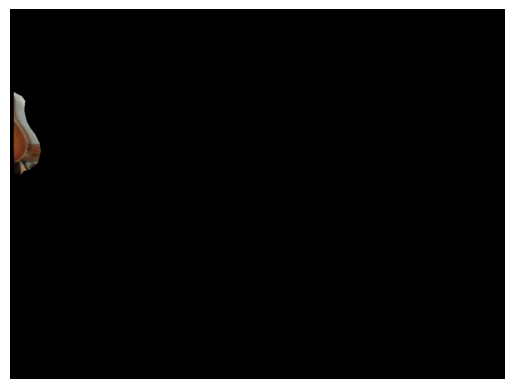

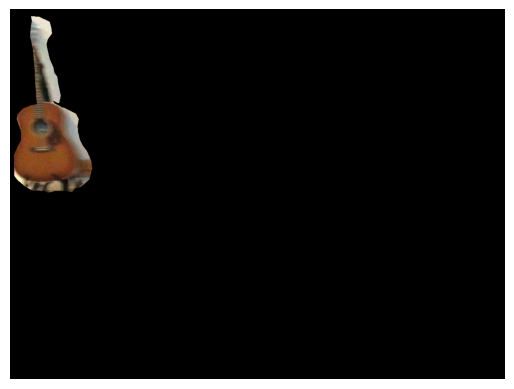

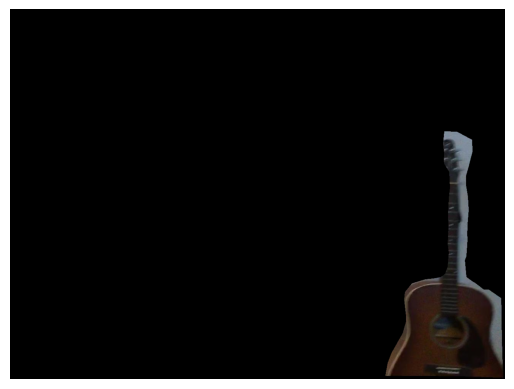

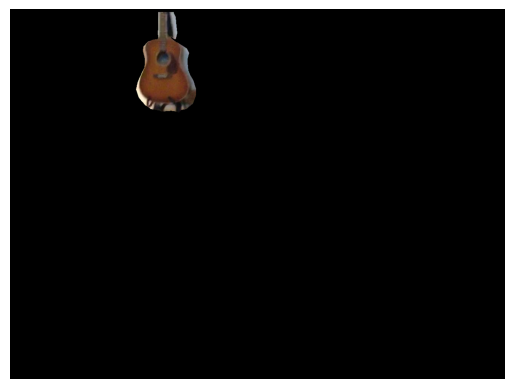

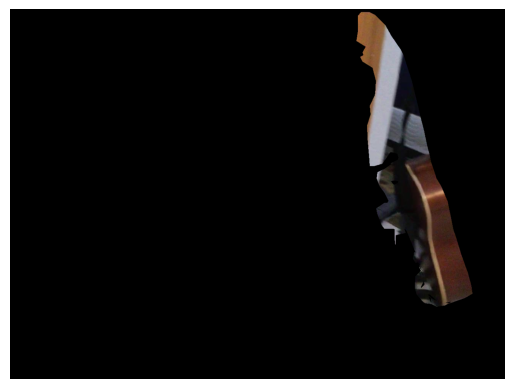

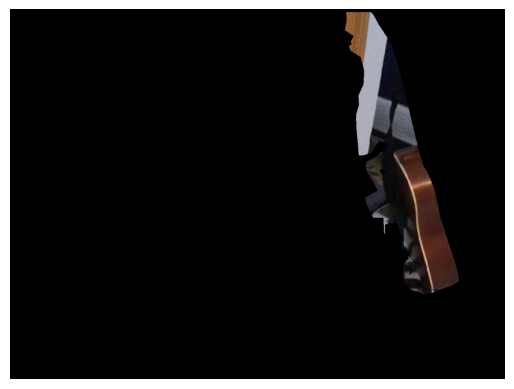

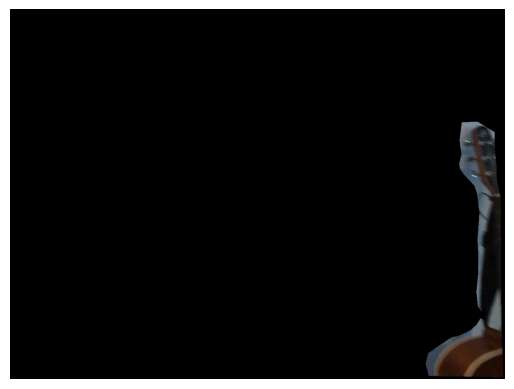

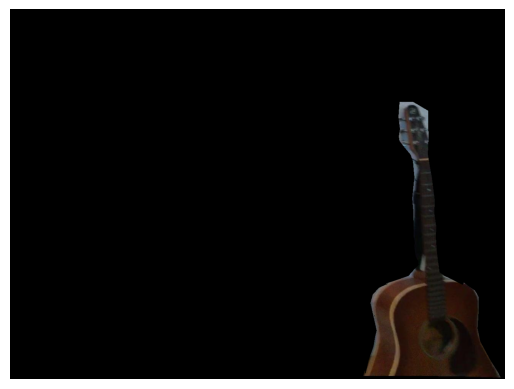

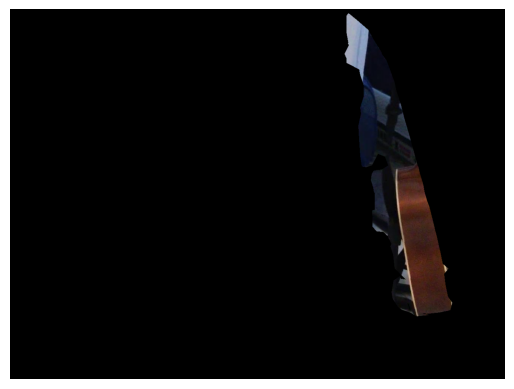

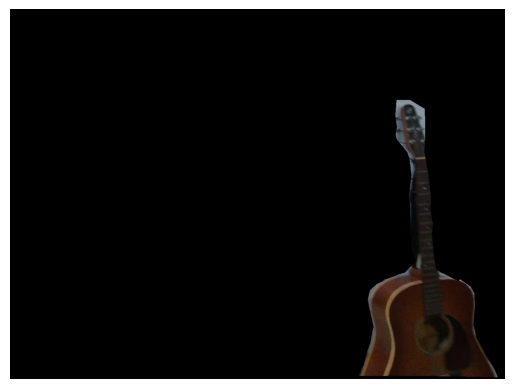

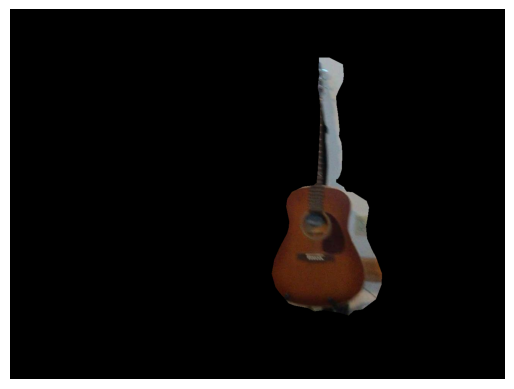

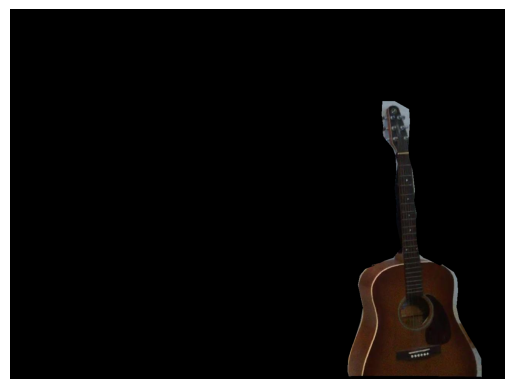

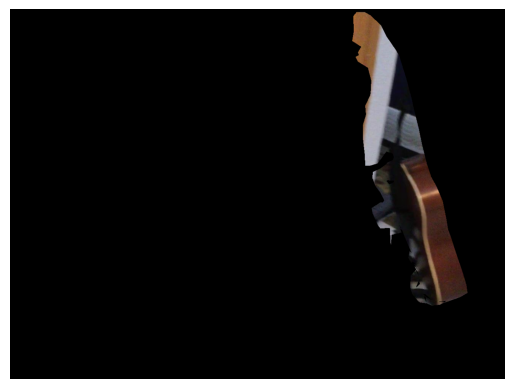

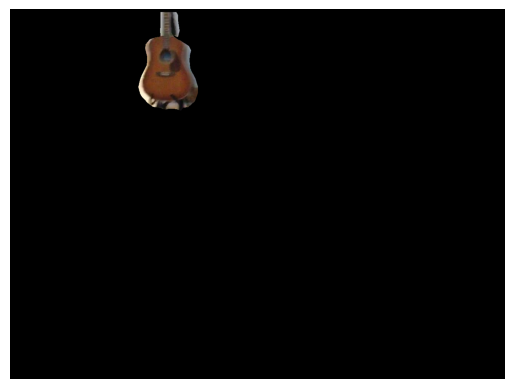

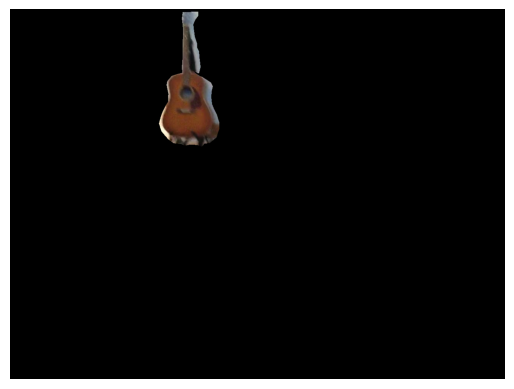

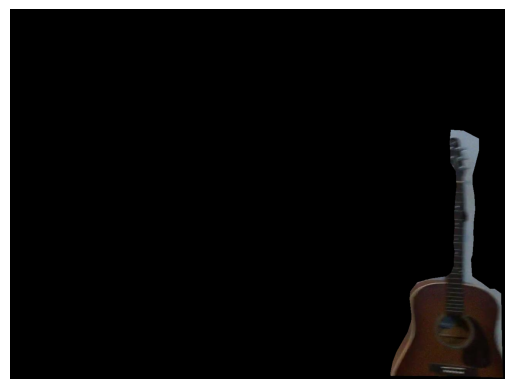

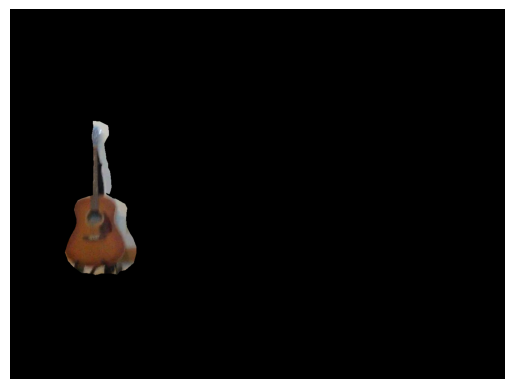

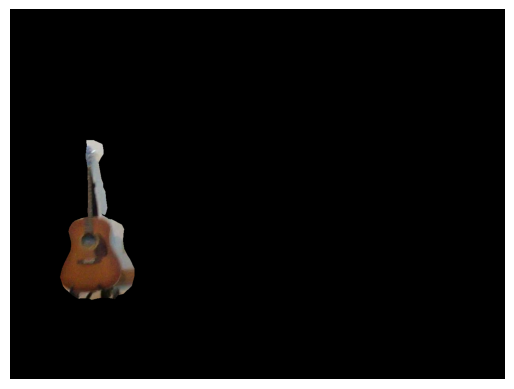

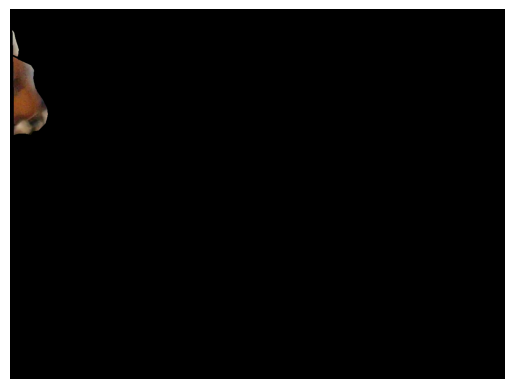

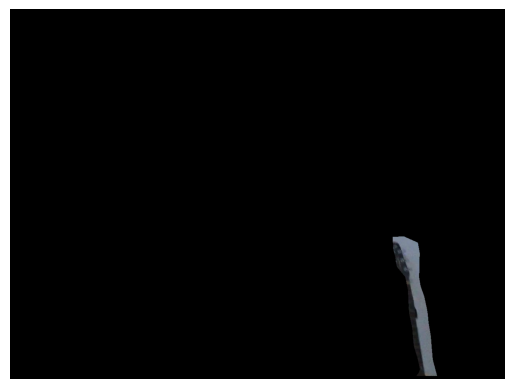

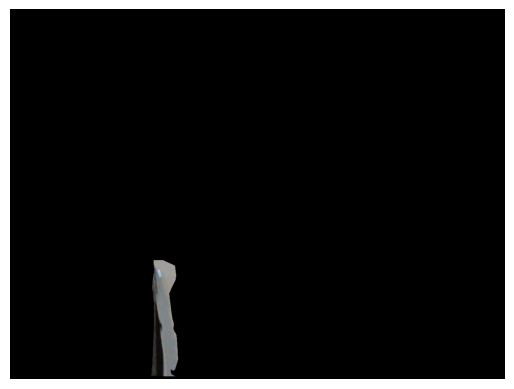

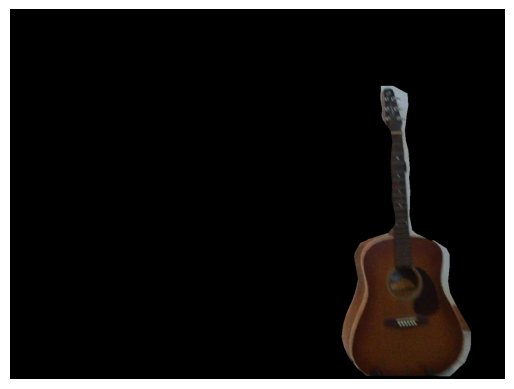

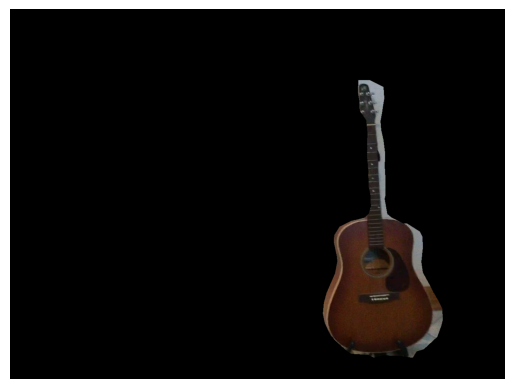

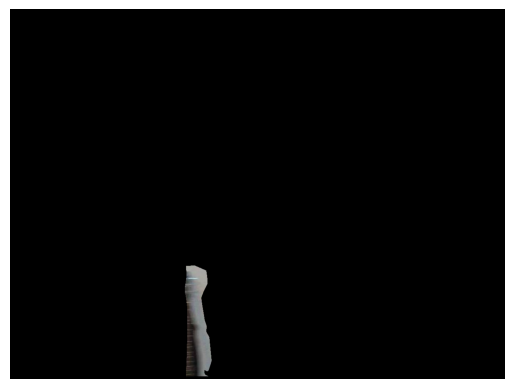

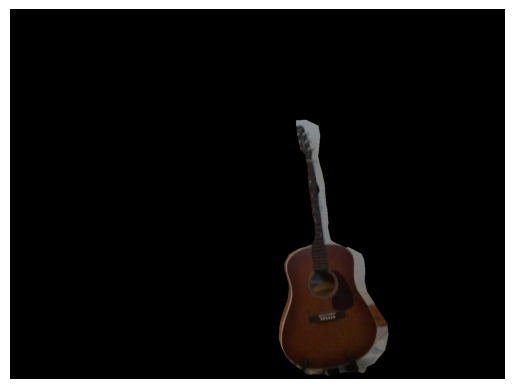

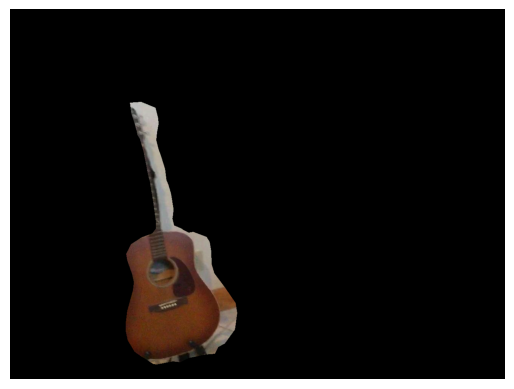

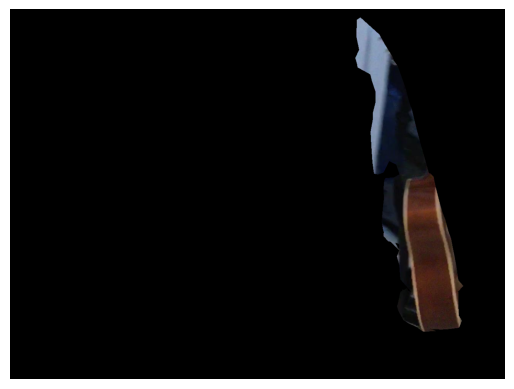

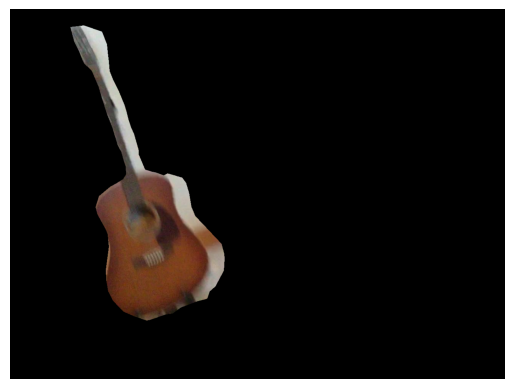

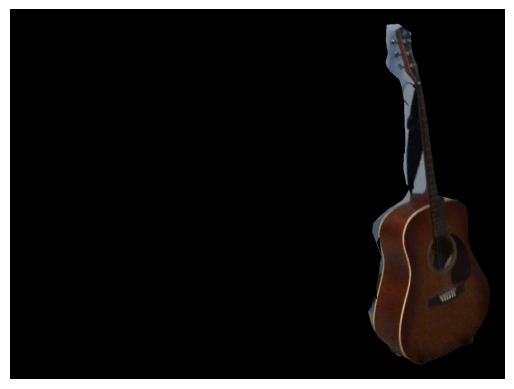

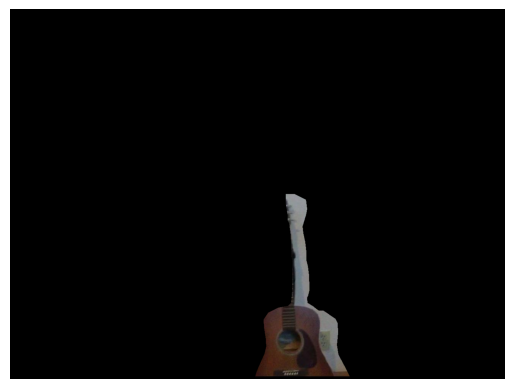

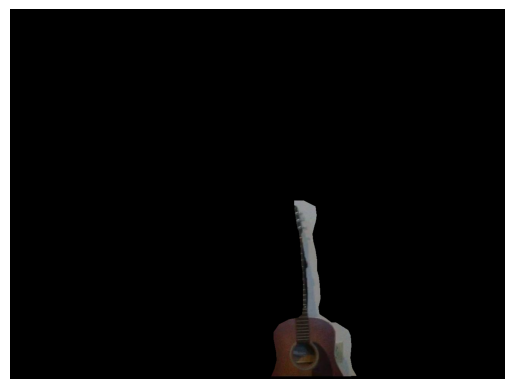

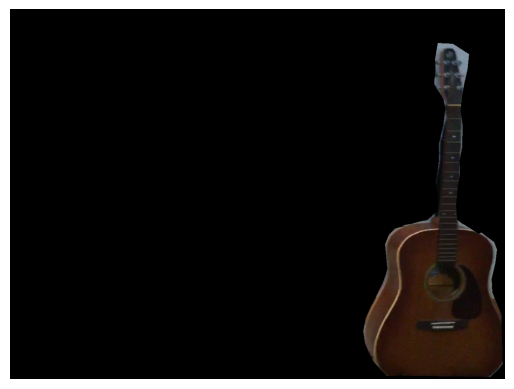

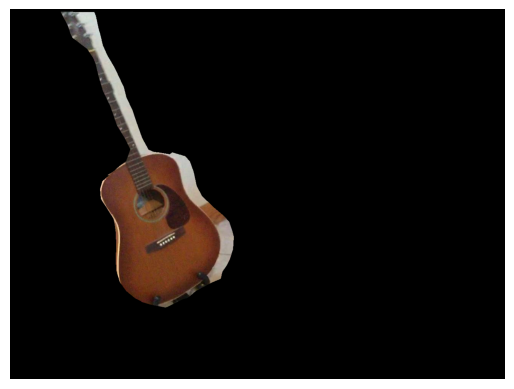

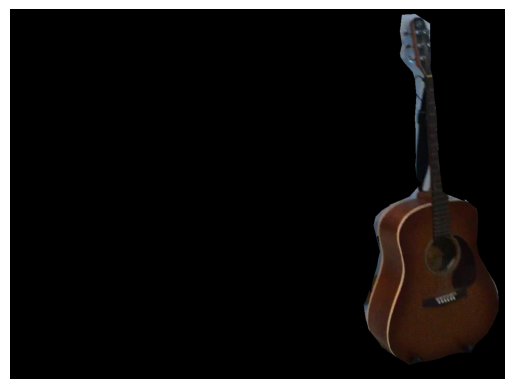

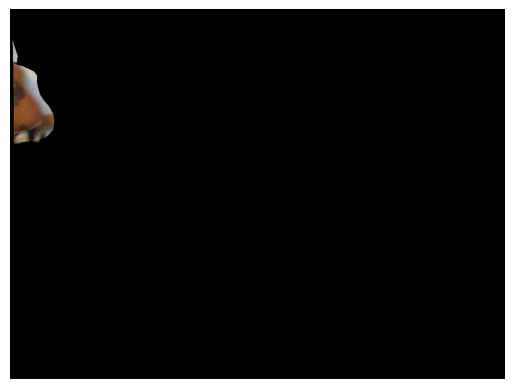

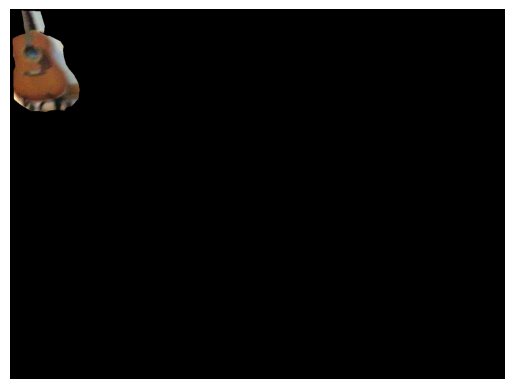

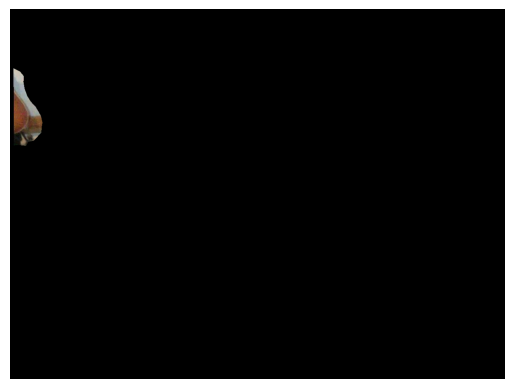

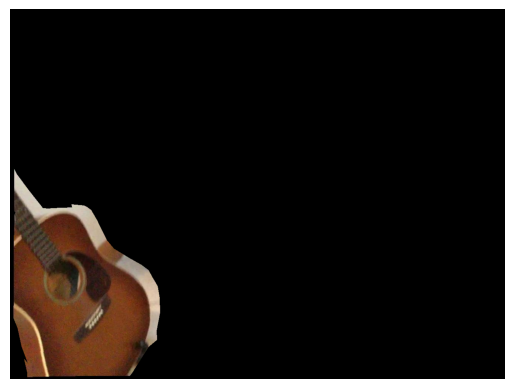

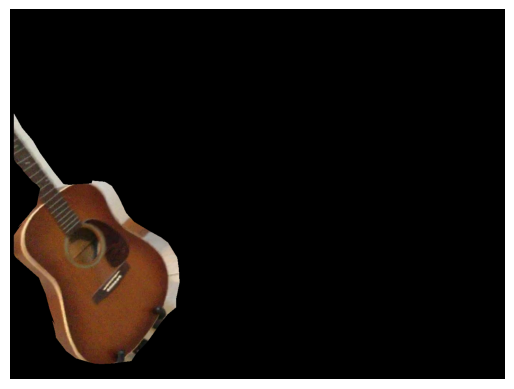

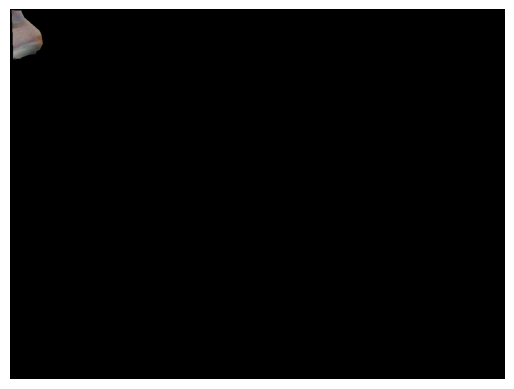

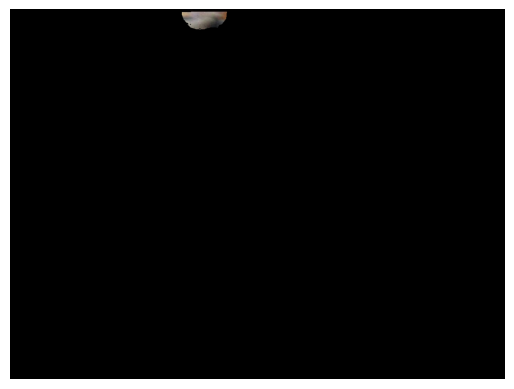

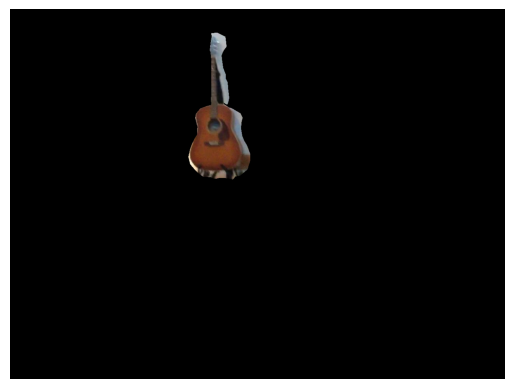

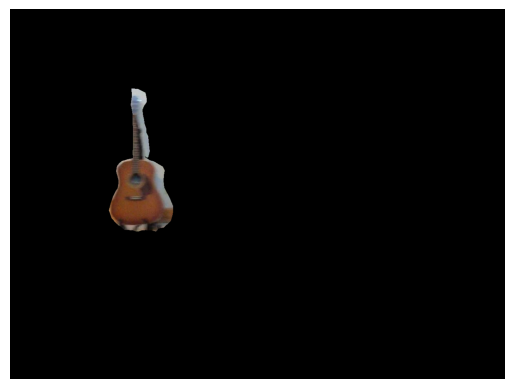

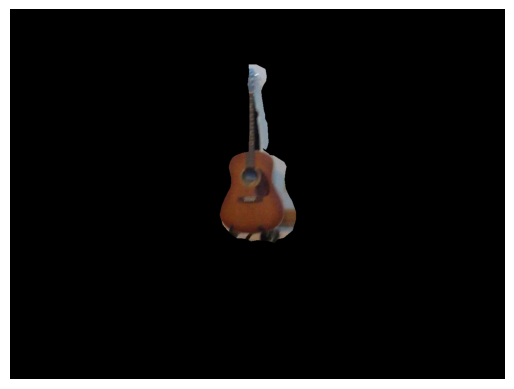

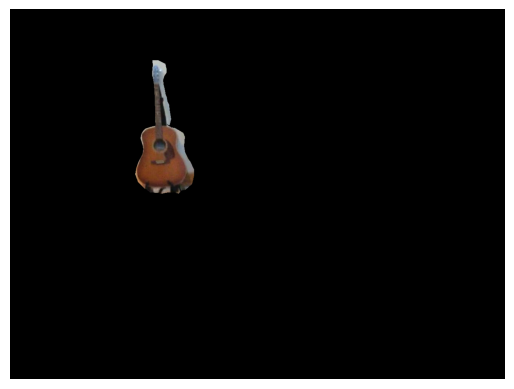

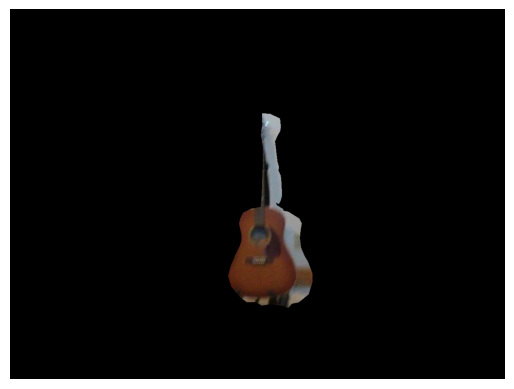

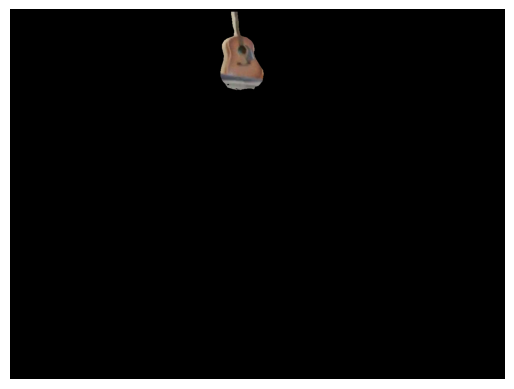

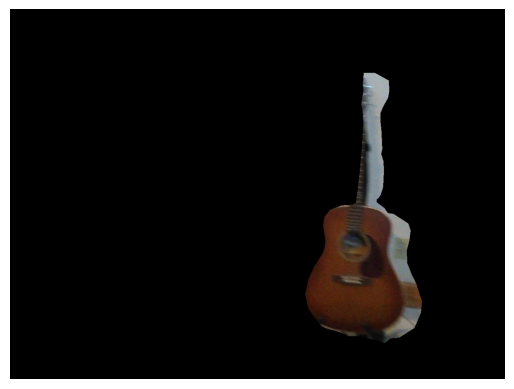

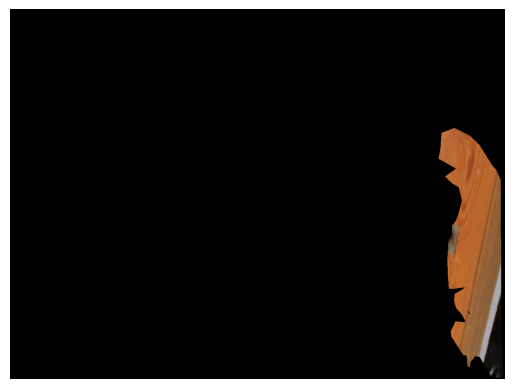

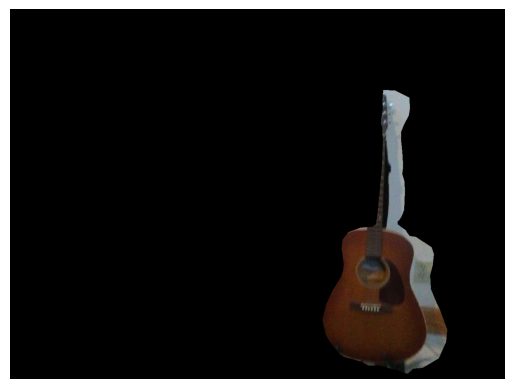

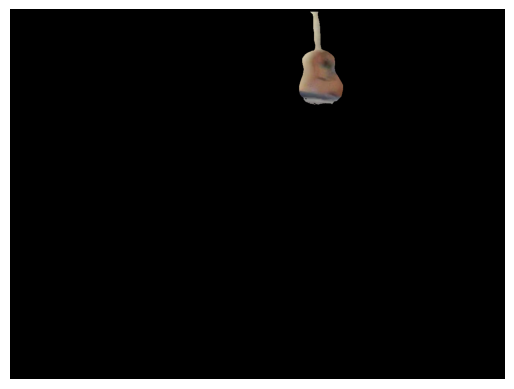

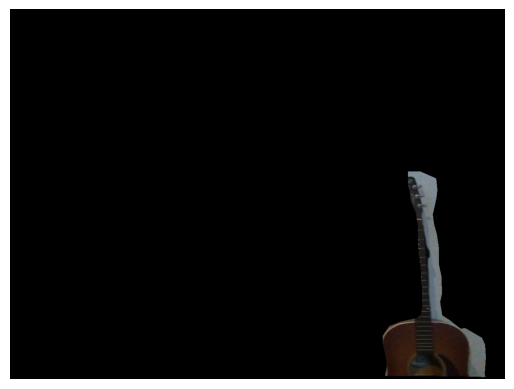

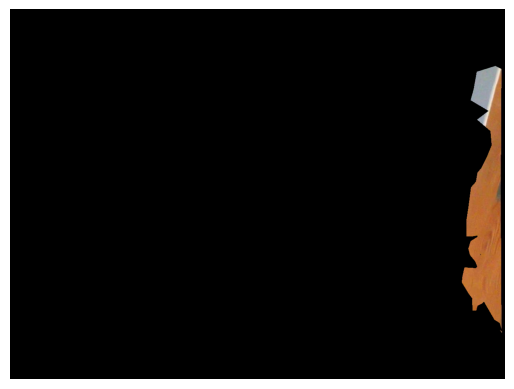

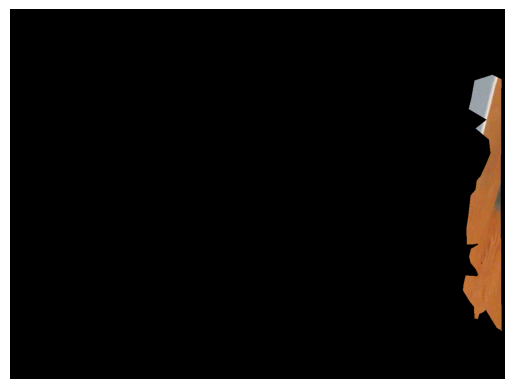

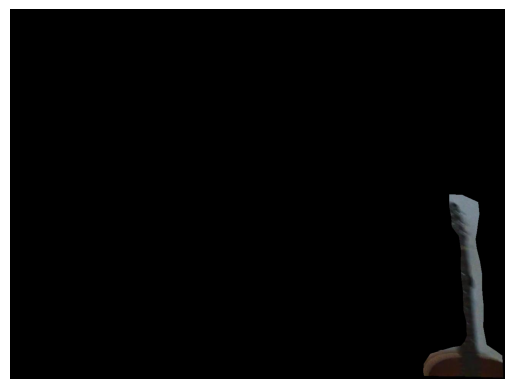

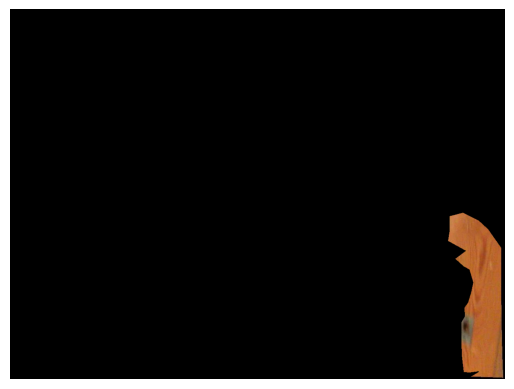

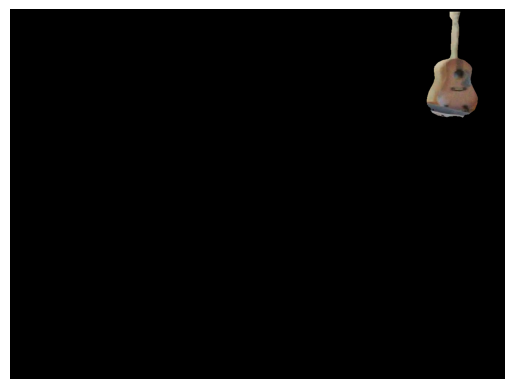

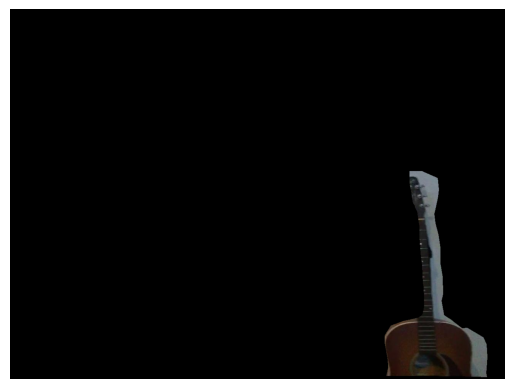

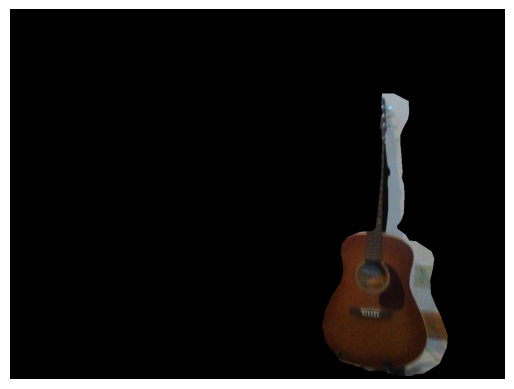

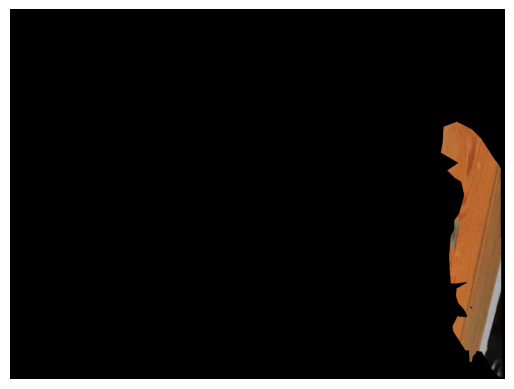

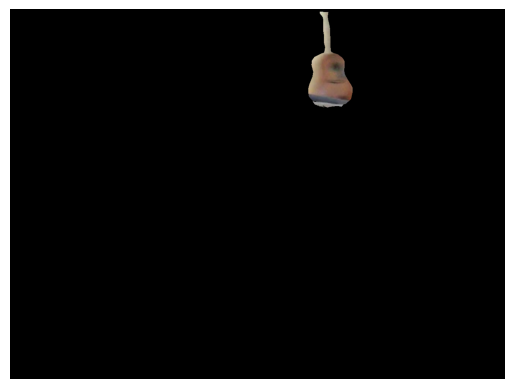

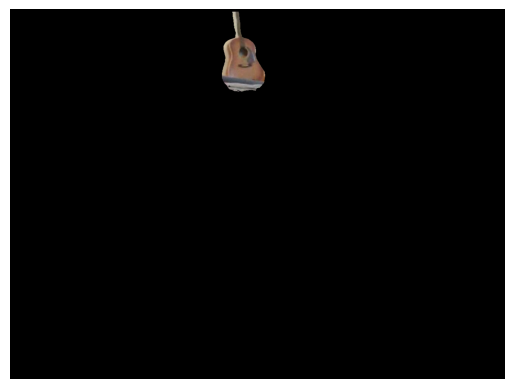

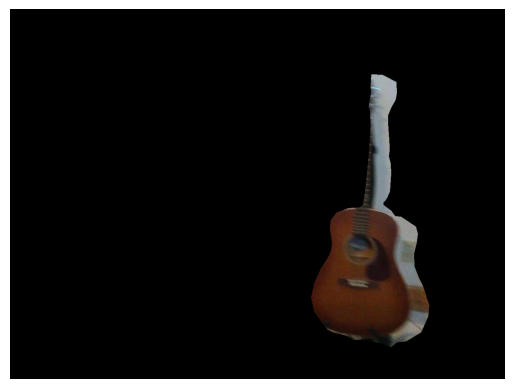

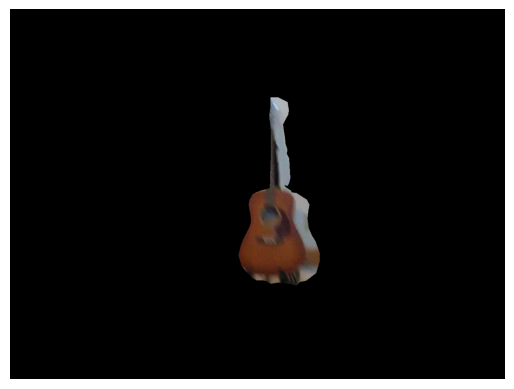

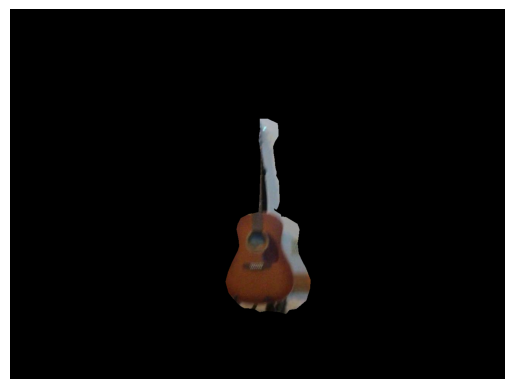

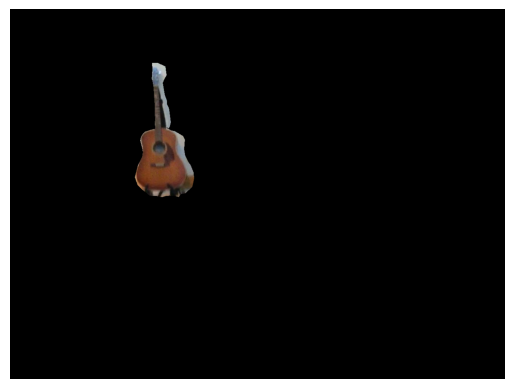

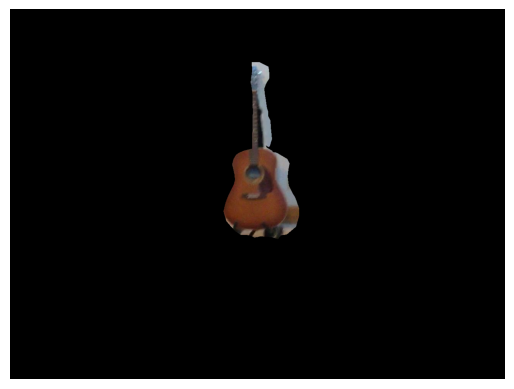

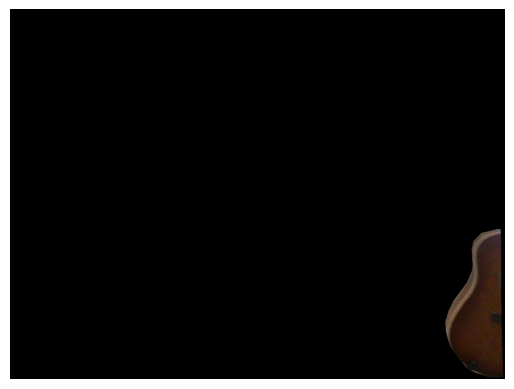

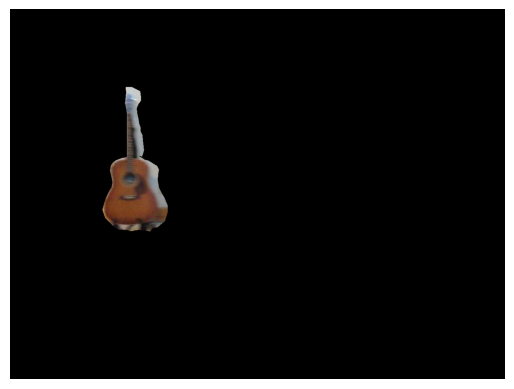

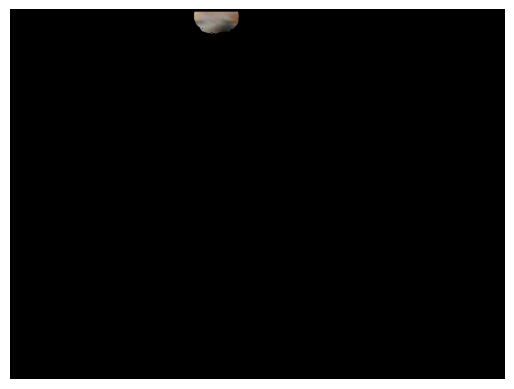

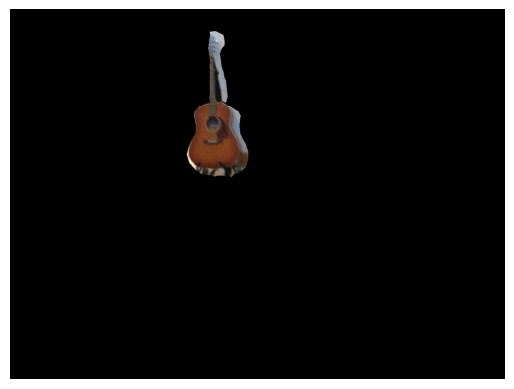

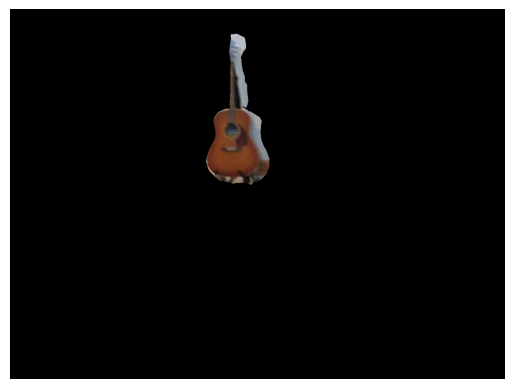

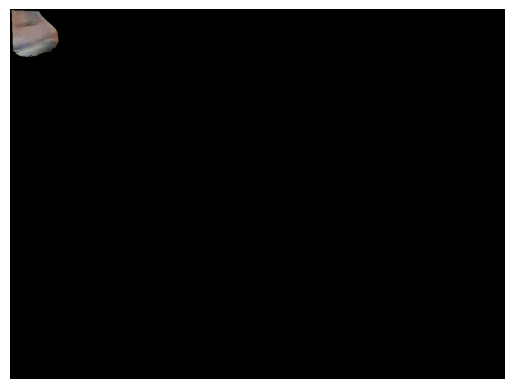

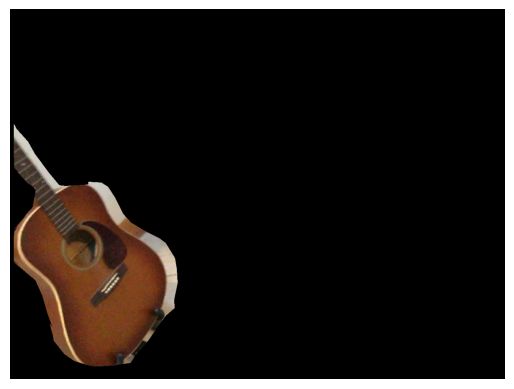

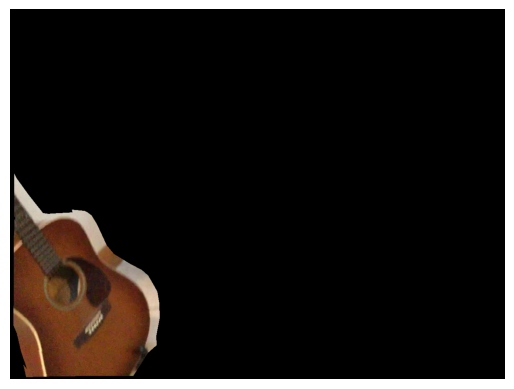

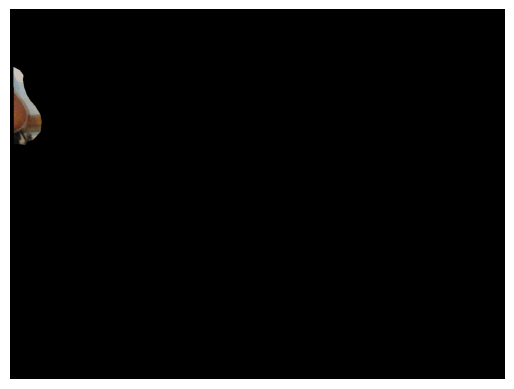

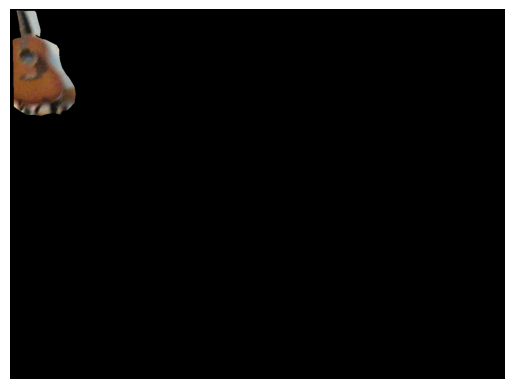

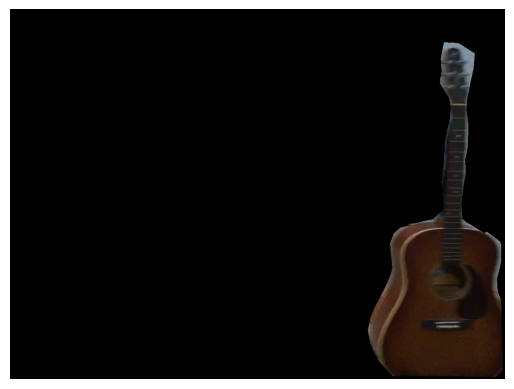

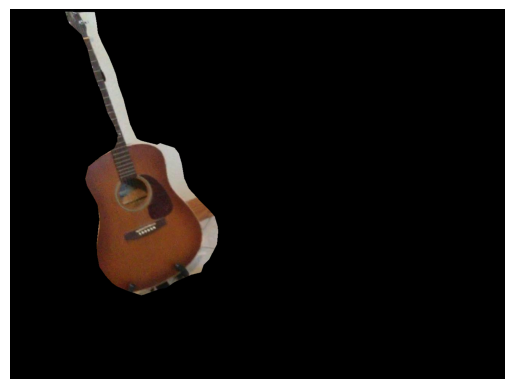

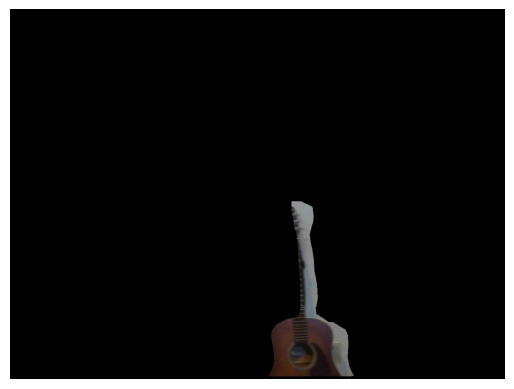

KeyboardInterrupt: 

In [7]:
selected_frames = []

def project_points(points_3d, intrinsic, extrinsic):
    # Add ones to 3D points to make them homogeneous for the extrinsic transformation
    points_3d_homogeneous = np.hstack([points_3d, np.ones((points_3d.shape[0], 1))])
    # Transform points to camera coordinates using the extrinsic parameters
    points_camera = np.dot(extrinsic, points_3d_homogeneous.T).T
    # Extract only the x, y, z components because the intrinsic matrix is 3x3
    points_camera_xyz = points_camera[:, :3]
    # Project points onto the image plane using the intrinsic parameters
    points_image_homogeneous = np.dot(intrinsic, points_camera_xyz.T).T
    # Convert from homogeneous coordinates to 2D by dividing by the z component
    points_2d = points_image_homogeneous[:, :2] / points_image_homogeneous[:, 2, np.newaxis]
    return points_2d

def draw_triangle(img, vertices, color):
    cv2.fillConvexPoly(img, vertices, color)

for frame_index in frame_indices:
    pose_path = os.path.join(pose_directory, f"{frame_index}.txt")
    original_path = os.path.join(originals_directory, f"{frame_index}.jpg")
    pose = np.loadtxt(pose_path)
    original = cv2.imread(original_path)
    camera_extrinsics = np.linalg.inv(pose)

    # Project the object vertices to 2D for the current frame
    object_vertices_2d = project_points(np.asarray(instance_mesh.vertices), camera_intrinsics, camera_extrinsics)

    # Check if vertices are within the image bounds
    in_bounds = (object_vertices_2d[:, 0] >= 0) & (object_vertices_2d[:, 0] < image_width) & \
                (object_vertices_2d[:, 1] >= 0) & (object_vertices_2d[:, 1] < image_height)

    if np.sum(in_bounds) >= minimum_vertices:
        selected_frames.append(frame_index)
        image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
        for face in instance_mesh.triangles:
            pts_2d = np.array(object_vertices_2d[face], dtype=np.int32)
            color_bgr = (255, 255, 255)
            draw_triangle(image, pts_2d, color_bgr)
        gray_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)
        
        # Ensure the mask is the same size as the original image (it should be, based on your code)
        masked_image = cv2.bitwise_and(original, original, mask=binary_mask)

        plt.figure()
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()